In [1]:
pip install pmdarima

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


***Importing the necessary modules***

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson 
from statsmodels.regression.linear_model import OLS 
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from pmdarima import auto_arima
import numpy as np
from statsmodels.tsa.stattools import adfuller
from sklearn import metrics
from timeit import default_timer as timer
import warnings
warnings.filterwarnings("ignore")

Reading the data

In [18]:
data=pd.read_csv('/Users/Anoop_Sigmoid/Downloads/Mock_Project/Demand_forecasting.csv')

In [19]:
data.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,TYPE_C,2.0,Beverages,Thai
1,1466964,1,55,1993,136.83,135.83,0,0,270,647,56,TYPE_C,2.0,Beverages,Thai
2,1346989,1,55,2539,134.86,135.86,0,0,189,647,56,TYPE_C,2.0,Beverages,Thai
3,1338232,1,55,2139,339.50,437.53,0,0,54,647,56,TYPE_C,2.0,Beverages,Indian
4,1448490,1,55,2631,243.50,242.50,0,0,40,647,56,TYPE_C,2.0,Beverages,Indian


In [20]:
data.describe()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,op_area
count,4.237270e+05,423727.000000,423727.000000,423727.000000,423727.000000,423727.000000,423727.000000,423727.000000,423727.000000,423727.000000,423727.000000,423727.000000
mean,1.249964e+06,69.677332,82.109469,2023.956295,329.516153,352.811156,0.083353,0.111315,264.550536,601.562478,56.609468,4.083245
std,1.443431e+05,38.686607,45.977420,547.370379,148.587055,158.933492,0.276416,0.314522,403.573030,66.206777,17.641225,1.091407
min,1.000000e+06,1.000000,10.000000,1062.000000,25.354881,55.350000,0.000000,0.000000,13.000000,456.000000,23.000000,0.900000
25%,1.124878e+06,37.000000,43.000000,1558.000000,228.010000,243.500000,0.000000,0.000000,54.000000,553.000000,34.000000,3.600000
50%,1.249955e+06,70.000000,76.000000,1971.000000,292.030000,309.490000,0.000000,0.000000,136.000000,596.000000,56.000000,4.000000
75%,1.374949e+06,103.000000,110.000000,2539.000000,444.290000,458.870000,0.000000,0.000000,324.000000,651.000000,77.000000,4.500000
max,1.499999e+06,135.000000,186.000000,2956.000000,637.697452,675.571407,1.000000,1.000000,24299.000000,713.000000,93.000000,7.000000


Identifying the features, for a certain center and meal id combination

In [21]:
data1=data[(data['center_id']==13)&(data['meal_id']==2290)]

Aggregated the data weekwise to get the time-series components only according to week

In [22]:
data1=data1.groupby('week').sum()

In [23]:
decompose = sm.tsa.seasonal_decompose(x=data1['num_orders'],model='additive',period=1)

Decomposing to identify various components

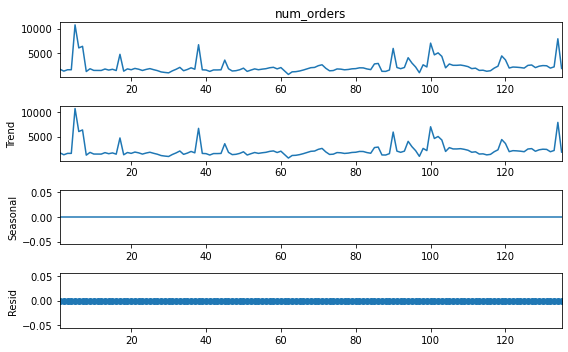

In [24]:
decompose.plot()
plt.show()

Only there is some trend component and random residual component

In [25]:
data1=data1[['checkout_price','base_price','emailer_for_promotion','homepage_featured','num_orders']]

In [26]:
data1

,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
week,,,,,
1,279.36,281.36,0,0,1688
2,311.43,311.43,0,0,1310
3,309.43,309.43,0,0,1593
4,309.43,311.43,0,0,1593
5,162.02,311.43,1,1,10745
...,...,...,...,...,...
131,293.91,294.91,0,0,2404
132,281.33,281.33,0,0,1930
133,298.79,299.79,0,0,2186


Identifying time series component of other important continious features compared with our target variable num_orders which is also a time series

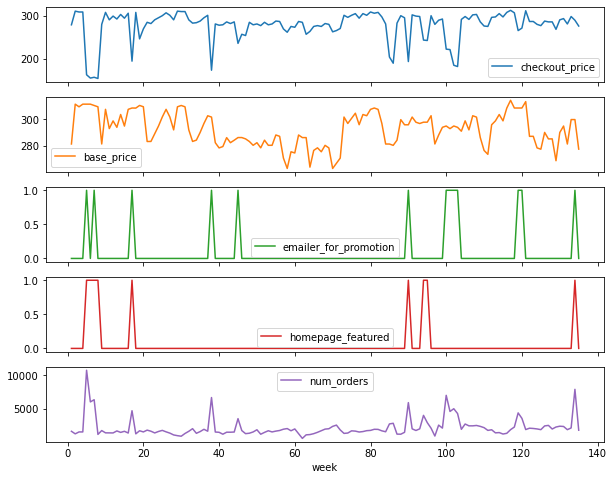

In [27]:
data1.plot(subplots=True,figsize=(10, 8))
plt.show()

Time series evaluation metrics function

In [28]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')


Function for augmented dickey fuller test

In [29]:
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

Function for cointegration test

In [30]:
def cointegration_test(df): 
    res = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = res.lr1
    cvts = res.cvt[:, d[str(1-0.05)]]
    def adjust(val, length= 6): 
        return str(val).ljust(length)
    print('Column Name   >  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), '> ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)


The inverse difference function, after de trending the data for model fitting we will need to re add the results again in order to get the predictions, this function does that

In [31]:
def inverse_diff(actual_df, pred_df):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns: 
        df_res[str(col)+'_1st_inv_diff'] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
    return df_res

ADF test for non-stationarity

In [32]:
for name, column in data1[['checkout_price', 'base_price', 'num_orders','emailer_for_promotion','homepage_featured']].iteritems():
    Augmented_Dickey_Fuller_Test_func(data1[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: checkout_price
Test Statistic                -7.000381e+00
p-value                        7.348040e-10
No Lags Used                   0.000000e+00
Number of Observations Used    1.340000e+02
Critical Value (1%)           -3.480119e+00
Critical Value (5%)           -2.883362e+00
Critical Value (10%)          -2.578407e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: base_price
Test Statistic                  -5.026963
p-value                          0.000020
No Lags Used                     0.000000
Number of Observations Used    134.000000
Critical Value (1%)             -3.480119
Critical Value (5%)             -2.883362
Critical Value (10%)            -2.578407
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: num_orders
Test Statistic                -8.402653e+00
p-value                        

Some columns are non stationary, so split the data into train test and de-trended the train data for model fitting

In [33]:
X = data1[['checkout_price', 'base_price', 'num_orders','emailer_for_promotion','homepage_featured']]
train, test = X[0:-15], X[-15:]

In [34]:
train_diff = train.diff()
train_diff.dropna(inplace = True)

Again performed ADF test and found out all the columns to be stationary

In [35]:
for name, column in train_diff[['checkout_price', 'base_price', 'num_orders','emailer_for_promotion','homepage_featured']].iteritems():
    Augmented_Dickey_Fuller_Test_func(train_diff[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: checkout_price
Test Statistic                -6.476779e+00
p-value                        1.325116e-08
No Lags Used                   7.000000e+00
Number of Observations Used    1.110000e+02
Critical Value (1%)           -3.490683e+00
Critical Value (5%)           -2.887952e+00
Critical Value (10%)          -2.580857e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: base_price
Test Statistic                -7.535647e+00
p-value                        3.484293e-11
No Lags Used                   4.000000e+00
Number of Observations Used    1.140000e+02
Critical Value (1%)           -3.489058e+00
Critical Value (5%)           -2.887246e+00
Critical Value (10%)          -2.580481e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: num_orders
Test Statistic                -6.068052e+00
p-value          

Te

In [36]:
cointegration_test(train_diff[['checkout_price', 'base_price', 'num_orders','emailer_for_promotion','homepage_featured']])

Column Name   >  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
checkout_price >  198.87    > 60.0627   =>   True
base_price >  143.15    > 40.1749   =>   True
num_orders >  93.37     > 24.2761   =>   True
emailer_for_promotion >  56.98     > 12.3212   =>   True
homepage_featured >  25.17     > 4.1296    =>   True


Finding optimal p,q for ARIMA

In [37]:
pq = []
for name, column in train_diff[[ 'checkout_price', 'base_price', 'num_orders' , 'emailer_for_promotion','homepage_featured']].iteritems():
    print(f'Searching order of p and q for : {name}')
    stepwise_model = auto_arima(train_diff[name],start_p=1, start_q=1,max_p=7, max_q=7, seasonal=True,
        trace=True,error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=10000)
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : checkout_price
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1209.940, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1203.679, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1200.450, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1207.941, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1198.453, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1201.681, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 2.153 seconds
optimal order for:checkout_price is: (0, 0, 1) 


Searching order of p

In [38]:
pq

[(0, 0, 1), (1, 0, 1), (0, 0, 2), (1, 0, 1), (1, 0, 1)]

Model fitting and storing the metrics

In [39]:
df_results = pd.DataFrame(columns=['p', 'q','checkout_price', 'base_price', 'num_orders', 'emailer_for_promotion','homepage_featured'])
print('Grid Search Started')
start = timer()
for i in pq:
    if i[0]== 0 and i[2] ==0:
        pass
    else:
        print(f' Running for {i}')
        model = VARMAX(train_diff[[ 'checkout_price', 'base_price', 'num_orders', 'emailer_for_promotion','homepage_featured'   ]], order=(i[0],i[2])).fit( disp=False)
        result = model.forecast(steps = 15)
        inv_res = inverse_diff(data1[[ 'checkout_price', 'base_price', 'num_orders' , 'emailer_for_promotion','homepage_featured'  ]] , result)
        pricerms = np.sqrt(metrics.mean_squared_error(test['checkout_price'], inv_res.checkout_price_1st_inv_diff))
        basepricerms = np.sqrt(metrics.mean_squared_error(test['base_price'], inv_res.base_price_1st_inv_diff))
        orderrms = np.sqrt(metrics.mean_squared_error(test['num_orders'], inv_res.num_orders_1st_inv_diff))
        promorms = np.sqrt(metrics.mean_squared_error(test['emailer_for_promotion'], inv_res.num_orders_1st_inv_diff))
        homerms = np.sqrt(metrics.mean_squared_error(test['homepage_featured'], inv_res.num_orders_1st_inv_diff))
        df_results = df_results.append({'p': i[0], 'q': i[2], 'RMSE price':pricerms,'RMSE baseprice':basepricerms,'RMSE order':orderrms,'RMSE promo':promorms,'RMSE feat':homerms}, ignore_index=True)
end = timer()
print(f' Total time taken to complete grid search in seconds: {(end - start)}')


Grid Search Started
 Running for (0, 0, 1)
 Running for (1, 0, 1)
 Running for (0, 0, 2)
 Running for (1, 0, 1)
 Running for (1, 0, 1)
 Total time taken to complete grid search in seconds: 15.26823258299919


In [40]:
df_results.sort_values(by = ['checkout_price', 'base_price', 'num_orders', 'emailer_for_promotion','homepage_featured'] )


,p,q,checkout_price,base_price,num_orders,emailer_for_promotion,homepage_featured,RMSE baseprice,RMSE feat,RMSE order,RMSE price,RMSE promo
0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,13.794727,2039.732746,1514.129976,15.386227,2039.732746
1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,14.085390,2100.317352,1496.610995,14.869328,2100.317352
2,0.0,2.0,NaN,NaN,NaN,NaN,NaN,14.838286,1563.832937,1738.107859,25.638875,1563.832937
3,1.0,1.0,NaN,NaN,NaN,NaN,NaN,14.085390,2100.317352,1496.610995,14.869328,2100.317352
4,1.0,1.0,NaN,NaN,NaN,NaN,NaN,14.085390,2100.317352,1496.610995,14.869328,2100.317352


In [41]:
model = VARMAX(train_diff[[ 'checkout_price', 'base_price', 'num_orders' ,'emailer_for_promotion','homepage_featured' ]], order=(0,1)).fit( disp=False)
result = model.forecast(steps = 15)


Final result after adding the differences back, using inverse diff

In [42]:
res = inverse_diff(data1[['checkout_price', 'base_price', 'num_orders','emailer_for_promotion','homepage_featured' ]],result)

In [43]:
res

,checkout_price,base_price,num_orders,emailer_for_promotion,homepage_featured,checkout_price_1st_inv_diff,base_price_1st_inv_diff,num_orders_1st_inv_diff,emailer_for_promotion_1st_inv_diff,homepage_featured_1st_inv_diff
119,-0.842123,0.158095,75.850000,0.042887,-0.007685,275.637877,277.638095,1925.850000,0.042887,-0.007685
120,-0.064479,0.225233,16.109252,0.008655,-0.000166,275.573398,277.863328,1941.959253,0.051542,-0.007851
121,-0.064479,0.225233,16.109252,0.008655,-0.000166,275.508919,278.088561,1958.068505,0.060197,-0.008017
122,-0.064479,0.225233,16.109252,0.008655,-0.000166,275.444441,278.313793,1974.177757,0.068852,-0.008183
123,-0.064479,0.225233,16.109252,0.008655,-0.000166,275.379962,278.539026,1990.287009,0.077507,-0.008349
124,-0.064479,0.225233,16.109252,0.008655,-0.000166,275.315484,278.764259,2006.396261,0.086162,-0.008514
125,-0.064479,0.225233,16.109252,0.008655,-0.000166,275.251005,278.989492,2022.505513,0.094817,-0.008680
126,-0.064479,0.225233,16.109252,0.008655,-0.000166,275.186527,279.214725,2038.614765,0.103472,-0.008846
127,-0.064479,0.225233,16.109252,0.008655,-0.000166,275.122048,279.439957,2054.724018,0.112128,-0.009012
128,-0.064479,0.225233,16.109252,0.008655,-0.000166,275.057570,279.665190,2070.833270,0.120783,-0.009178


Evaluation

In [44]:
for i in ['checkout_price', 'base_price', 'num_orders','emailer_for_promotion','homepage_featured']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(test[str(i)] , res[str(i)+'_1st_inv_diff'])

Evaluation metric for checkout_price
Evaluation metric results:-
MSE is : 236.73599547952352
MAE is : 12.679746387230603
RMSE is : 15.386227460931531
MAPE is : 4.326826651316039
R2 is : -1.4168984893673078

Evaluation metric for base_price
Evaluation metric results:-
MSE is : 190.2944964254423
MAE is : 10.535320445335708
RMSE is : 13.794727123993512
MAPE is : 3.5708198808405993
R2 is : -0.6560144426862247

Evaluation metric for num_orders
Evaluation metric results:-
MSE is : 2292589.583075747
MAE is : 586.7629784185652
RMSE is : 1514.1299756215603
MAPE is : 13.734378916473208
R2 is : -0.09242778439374244

Evaluation metric for emailer_for_promotion
Evaluation metric results:-
MSE is : 0.058051129141996595
MAE is : 0.14941867762037928
RMSE is : 0.24093801929541256
MAPE is : inf
R2 is : 0.06703542450362632

Evaluation metric for homepage_featured
Evaluation metric results:-
MSE is : 0.06805758756729675
MAE is : 0.07551281058171001
RMSE is : 0.26087849195994817
MAPE is : inf
R2 is : -0.09

Forecast

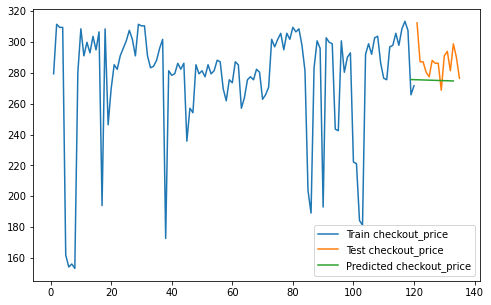

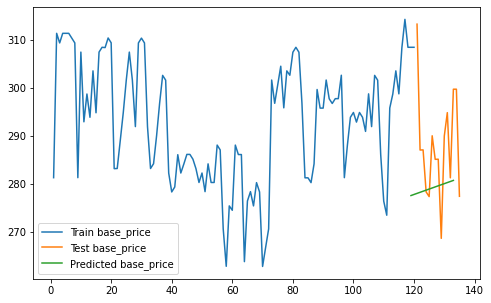

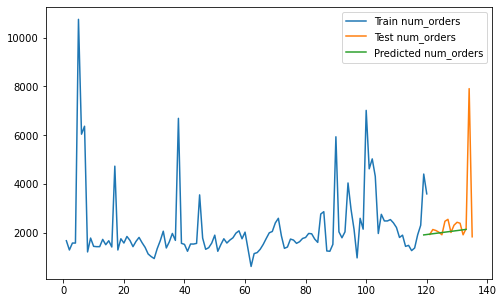

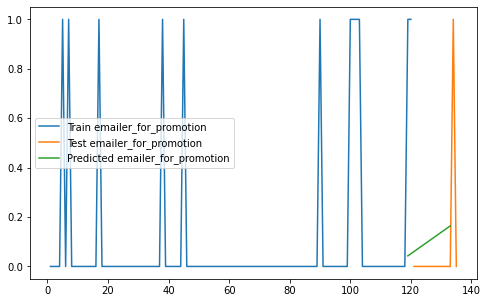

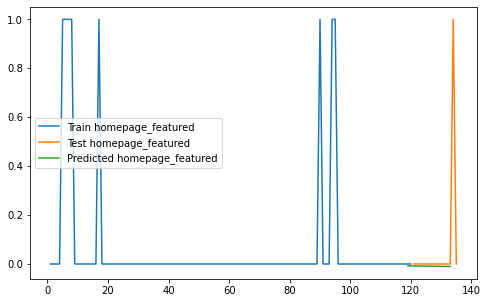

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline
for i in ['checkout_price', 'base_price', 'num_orders', 'emailer_for_promotion','homepage_featured']:
    
    plt.rcParams["figure.figsize"] = [8,5]
    plt.plot( train[str(i)], label='Train '+str(i))
    plt.plot(test[str(i)], label='Test '+str(i))
    plt.plot(res[str(i)+'_1st_inv_diff'], label='Predicted '+str(i))
    plt.legend(loc='best')
    plt.show()

The forecasts did not predict the up-down very well

In [46]:
data

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,TYPE_C,2.0,Beverages,Thai
1,1466964,1,55,1993,136.83,135.83,0,0,270,647,56,TYPE_C,2.0,Beverages,Thai
2,1346989,1,55,2539,134.86,135.86,0,0,189,647,56,TYPE_C,2.0,Beverages,Thai
3,1338232,1,55,2139,339.50,437.53,0,0,54,647,56,TYPE_C,2.0,Beverages,Indian
4,1448490,1,55,2631,243.50,242.50,0,0,40,647,56,TYPE_C,2.0,Beverages,Indian
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423722,1216825,135,61,1543,482.09,484.09,0,0,55,473,77,TYPE_A,4.5,Desert,Indian
423723,1140667,135,61,2304,483.09,482.09,0,0,13,473,77,TYPE_A,4.5,Desert,Indian
423724,1079935,135,61,2664,340.53,338.53,0,0,230,473,77,TYPE_A,4.5,Salad,Italian
423725,1166473,135,61,2569,329.86,329.86,0,0,432,473,77,TYPE_A,4.5,Salad,Italian


In [47]:
dat=data[['checkout_price','base_price','emailer_for_promotion','homepage_featured','num_orders']].groupby(data['week']).mean()


Grouped the continuous variables by week, took mean instead of sum

In [48]:
dat

,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
week,,,,,
1,329.862422,348.469226,0.122177,0.141684,271.136550
2,323.242988,347.281506,0.214434,0.177486,271.783149
3,326.471774,347.809276,0.035874,0.109003,239.828217
4,329.437325,348.341929,0.000000,0.101073,257.365524
5,315.170041,350.106868,0.117873,0.162994,419.263729
...,...,...,...,...,...
131,329.298634,362.241686,0.114789,0.173398,273.292742
132,331.762010,362.571799,0.086081,0.146520,286.744200
133,337.504725,363.994910,0.089651,0.126354,251.378761


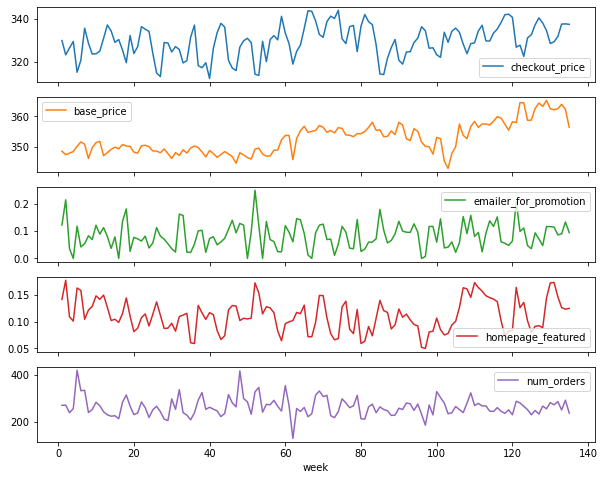

In [49]:
dat.plot(subplots=True,figsize=(10, 8))
plt.show()

In [50]:
for name, column in dat[['checkout_price', 'base_price', 'num_orders','emailer_for_promotion','homepage_featured']].iteritems():
    Augmented_Dickey_Fuller_Test_func(data1[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: checkout_price
Test Statistic                -7.000381e+00
p-value                        7.348040e-10
No Lags Used                   0.000000e+00
Number of Observations Used    1.340000e+02
Critical Value (1%)           -3.480119e+00
Critical Value (5%)           -2.883362e+00
Critical Value (10%)          -2.578407e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: base_price
Test Statistic                  -5.026963
p-value                          0.000020
No Lags Used                     0.000000
Number of Observations Used    134.000000
Critical Value (1%)             -3.480119
Critical Value (5%)             -2.883362
Critical Value (10%)            -2.578407
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: num_orders
Test Statistic                -8.402653e+00
p-value                        

In [51]:
X = dat[['checkout_price', 'base_price', 'num_orders','emailer_for_promotion','homepage_featured']]
train, test = X[0:-15], X[-15:]

In [52]:
train_diff = train.diff()
train_diff.dropna(inplace = True)

In [53]:
for name, column in train_diff[['checkout_price', 'base_price', 'num_orders','emailer_for_promotion','homepage_featured']].iteritems():
    Augmented_Dickey_Fuller_Test_func(train_diff[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: checkout_price
Test Statistic                -8.257385e+00
p-value                        5.192944e-13
No Lags Used                   5.000000e+00
Number of Observations Used    1.130000e+02
Critical Value (1%)           -3.489590e+00
Critical Value (5%)           -2.887477e+00
Critical Value (10%)          -2.580604e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: base_price
Test Statistic                -1.056994e+01
p-value                        7.349437e-19
No Lags Used                   2.000000e+00
Number of Observations Used    1.160000e+02
Critical Value (1%)           -3.488022e+00
Critical Value (5%)           -2.886797e+00
Critical Value (10%)          -2.580241e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: num_orders
Test Statistic                -6.001077e+00
p-value          

In [54]:
cointegration_test(train_diff[['checkout_price', 'base_price', 'num_orders','emailer_for_promotion','homepage_featured']])

Column Name   >  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
checkout_price >  201.17    > 60.0627   =>   True
base_price >  129.25    > 40.1749   =>   True
num_orders >  78.67     > 24.2761   =>   True
emailer_for_promotion >  42.55     > 12.3212   =>   True
homepage_featured >  11.08     > 4.1296    =>   True


In [55]:
exo=train_diff[['checkout_price', 'base_price', 'emailer_for_promotion','homepage_featured']]

Used exogenous variables while fitting in auto-arima


In [56]:
pq = []
for name, column in train_diff[[ 'checkout_price', 'base_price', 'num_orders' , 'emailer_for_promotion','homepage_featured']].iteritems():
    print(f'Searching order of p and q for : {name}')
    stepwise_model = auto_arima(train_diff[name],start_p=1, start_q=1,max_p=7, max_q=7, seasonal=True, X=exo, D=4,max_D=12,
        trace=True,error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=10000)
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : checkout_price
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-2505.473, Time=2.14 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-2509.473, Time=0.76 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-2507.472, Time=1.00 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-2507.469, Time=1.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-2511.480, Time=1.17 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 6.087 seconds
optimal order for:checkout_price is: (0, 0, 0) 


Searching order of p and q for : base_price
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-2505.473, Time=1.13 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-2509.473, Time=0.74 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-2507.473, Time=0.92 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-2507.473, Time=0.93 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-2511.480, Time=1.20 sec

Best model:  ARIMA(0,0,0

In [57]:
pq

[(0, 0, 0), (0, 0, 0), (1, 0, 1), (0, 0, 0), (0, 0, 0)]

In [58]:
df_results = pd.DataFrame(columns=['p', 'q','checkout_price', 'base_price', 'num_orders', 'emailer_for_promotion','homepage_featured'])
print('Grid Search Started')
start = timer()
for i in pq:
    if i[0]== 0 and i[2] ==0:
        pass
    else:
        print(f' Running for {i}')
        model = VARMAX(train_diff[[ 'checkout_price', 'base_price', 'num_orders', 'emailer_for_promotion','homepage_featured'   ]], order=(i[0],i[2])).fit( disp=False)
        result = model.forecast(steps = 15)
        inv_res = inverse_diff(data1[[ 'checkout_price', 'base_price', 'num_orders' , 'emailer_for_promotion','homepage_featured'  ]] , result)
        pricerms = np.sqrt(metrics.mean_squared_error(test['checkout_price'], inv_res.checkout_price_1st_inv_diff))
        basepricerms = np.sqrt(metrics.mean_squared_error(test['base_price'], inv_res.base_price_1st_inv_diff))
        orderrms = np.sqrt(metrics.mean_squared_error(test['num_orders'], inv_res.num_orders_1st_inv_diff))
        promorms = np.sqrt(metrics.mean_squared_error(test['emailer_for_promotion'], inv_res.num_orders_1st_inv_diff))
        homerms = np.sqrt(metrics.mean_squared_error(test['homepage_featured'], inv_res.num_orders_1st_inv_diff))
        df_results = df_results.append({'p': i[0], 'q': i[2], 'RMSE price':pricerms,'RMSE baseprice':basepricerms,'RMSE order':orderrms,'RMSE promo':promorms,'RMSE feat':homerms}, ignore_index=True)
end = timer()
print(f' Total time taken to complete grid search in seconds: {(end - start)}')


Grid Search Started
 Running for (1, 0, 1)
 Total time taken to complete grid search in seconds: 2.922318417000497


In [59]:
df_results.sort_values(by = ['checkout_price', 'base_price', 'num_orders', 'emailer_for_promotion','homepage_featured'] )


,p,q,checkout_price,base_price,num_orders,emailer_for_promotion,homepage_featured,RMSE baseprice,RMSE feat,RMSE order,RMSE price,RMSE promo
0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,84.28714,1857.219803,1593.920236,56.190362,1857.248317


In [60]:
model = VARMAX(train_diff[[ 'checkout_price', 'base_price', 'num_orders' ,'emailer_for_promotion','homepage_featured' ]], order=(2,0)).fit( disp=False)
result = model.forecast(steps = 15)


In [61]:
res = inverse_diff(dat[['checkout_price', 'base_price', 'num_orders','emailer_for_promotion','homepage_featured' ]],result)

In [47]:
res

,checkout_price,base_price,num_orders,emailer_for_promotion,homepage_featured,checkout_price_1st_inv_diff,base_price_1st_inv_diff,num_orders_1st_inv_diff,emailer_for_promotion_1st_inv_diff,homepage_featured_1st_inv_diff
129,5.252811,0.033279,-40.406517,-0.062629,-0.038302,350.268723,355.401149,165.201194,-0.017036,0.022592
130,1.933154,0.310718,-1.354345,0.025433,-0.001312,352.201876,355.711867,163.846849,0.008398,0.021279
131,-2.933552,0.378199,24.789069,0.025242,0.015817,349.268325,356.090066,188.635919,0.033639,0.037096
132,-0.124424,0.423680,-9.534982,-0.021007,-0.002874,349.143900,356.513746,179.100937,0.012632,0.034222
133,1.165999,-0.190601,-5.790738,-0.005049,-0.004632,350.309899,356.323144,173.310198,0.007583,0.029591
134,-0.040238,-0.007455,5.168859,0.008922,0.001469,350.269661,356.315689,178.479058,0.016505,0.031060
135,-0.362697,0.357431,0.304952,-0.000890,0.001445,349.906964,356.673120,178.784009,0.015615,0.032505
136,0.030097,0.186345,-0.930234,-0.002453,-0.000234,349.937061,356.859465,177.853775,0.013162,0.032271
137,0.169190,0.029562,0.228095,0.000194,-0.000365,350.106251,356.889027,178.081871,0.013356,0.031906
138,0.041836,0.130239,0.085242,-0.000170,0.000077,350.148086,357.019266,178.167113,0.013186,0.031983


In [48]:
for i in ['checkout_price', 'base_price', 'num_orders','emailer_for_promotion','homepage_featured']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(test[str(i)] , res[str(i)+'_1st_inv_diff'])

Evaluation metric for checkout_price
Evaluation metric results:-
MSE is : 119.21308277338811
MAE is : 9.855235347539914
RMSE is : 10.918474379389647
MAPE is : 2.9152317623367234
R2 is : -4.530985776570839

Evaluation metric for base_price
Evaluation metric results:-
MSE is : 41.38741159363254
MAE is : 5.223437709277145
RMSE is : 6.433304873362721
MAPE is : 1.4345227657116841
R2 is : -2.020296634272025

Evaluation metric for num_orders
Evaluation metric results:-
MSE is : 4893.438166471964
MAE is : 64.03279078308518
RMSE is : 69.95311405843177
MAPE is : 25.700703796962028
R2 is : -6.706049823474603

Evaluation metric for emailer_for_promotion
Evaluation metric results:-
MSE is : 0.004969629099695214
MAE is : 0.059482604765759804
RMSE is : 0.070495596314204
MAPE is : inf
R2 is : -2.5727185976361207

Evaluation metric for homepage_featured
Evaluation metric results:-
MSE is : 0.006089542549367581
MAE is : 0.06980801885129502
RMSE is : 0.07803552107449262
MAPE is : 65.44290913448765
R2 is 

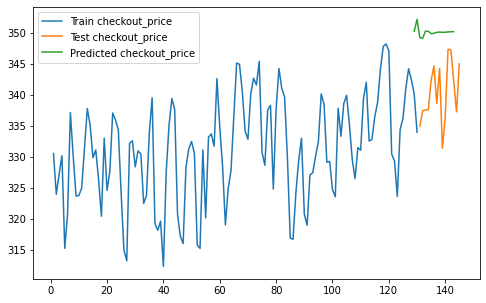

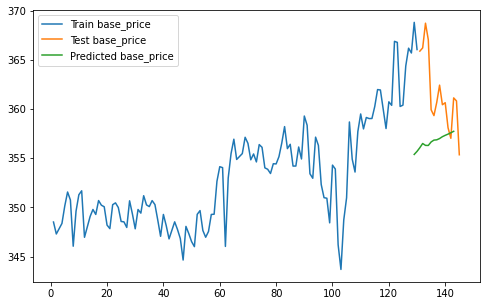

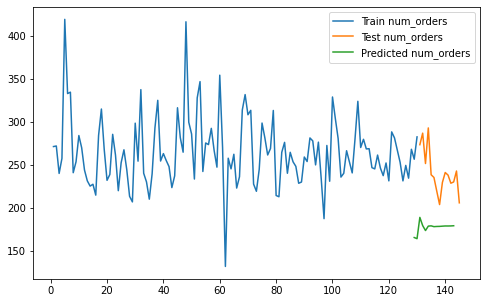

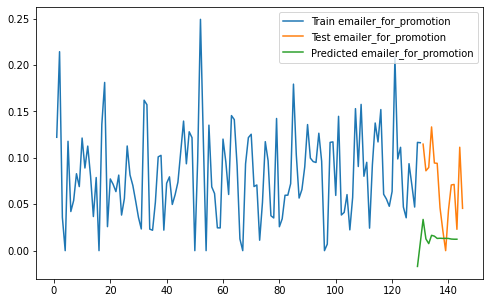

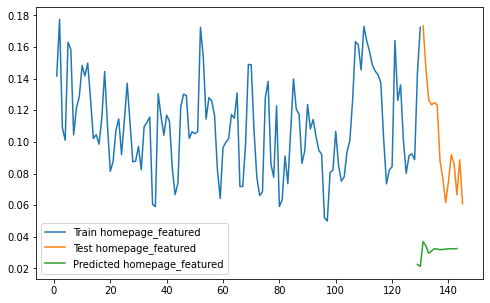

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline
for i in ['checkout_price', 'base_price', 'num_orders', 'emailer_for_promotion','homepage_featured']:
    
    plt.rcParams["figure.figsize"] = [8,5]
    plt.plot( train[str(i)], label='Train '+str(i))
    plt.plot(test[str(i)], label='Test '+str(i))
    plt.plot(res[str(i)+'_1st_inv_diff'], label='Predicted '+str(i))
    plt.legend(loc='best')
    plt.show()

In [50]:
model

In [51]:
res

,checkout_price,base_price,num_orders,emailer_for_promotion,homepage_featured,checkout_price_1st_inv_diff,base_price_1st_inv_diff,num_orders_1st_inv_diff,emailer_for_promotion_1st_inv_diff,homepage_featured_1st_inv_diff
129,5.252811,0.033279,-40.406517,-0.062629,-0.038302,350.268723,355.401149,165.201194,-0.017036,0.022592
130,1.933154,0.310718,-1.354345,0.025433,-0.001312,352.201876,355.711867,163.846849,0.008398,0.021279
131,-2.933552,0.378199,24.789069,0.025242,0.015817,349.268325,356.090066,188.635919,0.033639,0.037096
132,-0.124424,0.423680,-9.534982,-0.021007,-0.002874,349.143900,356.513746,179.100937,0.012632,0.034222
133,1.165999,-0.190601,-5.790738,-0.005049,-0.004632,350.309899,356.323144,173.310198,0.007583,0.029591
134,-0.040238,-0.007455,5.168859,0.008922,0.001469,350.269661,356.315689,178.479058,0.016505,0.031060
135,-0.362697,0.357431,0.304952,-0.000890,0.001445,349.906964,356.673120,178.784009,0.015615,0.032505
136,0.030097,0.186345,-0.930234,-0.002453,-0.000234,349.937061,356.859465,177.853775,0.013162,0.032271
137,0.169190,0.029562,0.228095,0.000194,-0.000365,350.106251,356.889027,178.081871,0.013356,0.031906
138,0.041836,0.130239,0.085242,-0.000170,0.000077,350.148086,357.019266,178.167113,0.013186,0.031983


In [52]:
pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 903.7/903.7 kB 7.2 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [53]:
from arch import arch_model
import arch.__future__
from arch.__future__ import reindexing

In [54]:
residual=model.resid

In [55]:
residual

,checkout_price,base_price,num_orders,emailer_for_promotion,homepage_featured
week,,,,,
2,-6.627634,-1.356855,0.525992,0.092487,0.035713
3,4.431352,0.126590,-41.850807,-0.148154,-0.070253
4,-2.057891,0.420079,31.155677,-0.062456,0.003055
5,-9.265690,2.543288,119.336730,-0.001583,0.029578
6,6.932501,1.581773,-31.838497,-0.049346,-0.004592
...,...,...,...,...,...
126,9.202669,1.486166,-5.206893,-0.002917,-0.009755
127,6.019576,1.840661,-26.415472,-0.017342,-0.012488
128,-2.563303,0.401575,45.841395,0.012985,0.006234


Applied arch deleted the code later it was also not giving good result

array([<AxesSubplot:xlabel='week'>, <AxesSubplot:xlabel='week'>,
       <AxesSubplot:xlabel='week'>, <AxesSubplot:xlabel='week'>,
       <AxesSubplot:xlabel='week'>], dtype=object)

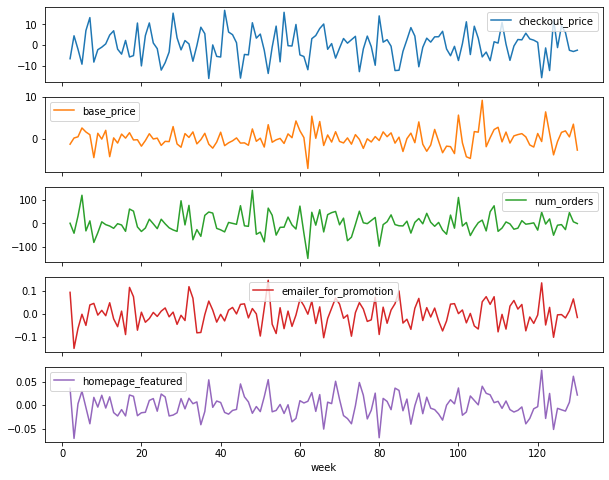

In [56]:
residual.plot(subplots=True,figsize=(10, 8))

In [57]:
test

,checkout_price,base_price,num_orders,emailer_for_promotion,homepage_featured
week,,,,,
131,334.959672,365.920380,273.292742,0.114789,0.173398
132,337.430256,366.250580,286.744200,0.086081,0.146520
133,337.585806,368.766736,251.378761,0.089651,0.126354
134,337.606372,367.074324,292.814414,0.133333,0.123423
135,342.337041,359.947998,238.302975,0.094450,0.124808
136,344.696746,359.355750,235.142988,0.094103,0.123434
137,338.614630,360.714831,219.232409,0.046299,0.088029
138,344.285546,362.458228,203.582367,0.021660,0.076876
139,331.366572,360.462351,229.318390,0.000000,0.061604


In [58]:
corr=dat.corr()

Finding correlation and removing columns

<AxesSubplot:>

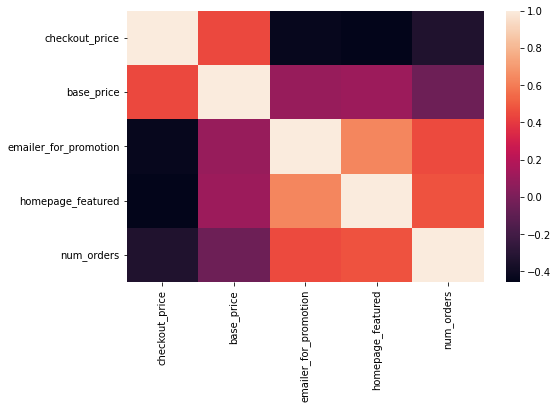

In [59]:
sns.heatmap(corr)

In [60]:
dat

,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
week,,,,,
1,330.530205,348.516537,0.122177,0.141684,271.136550
2,323.926944,347.299448,0.214434,0.177486,271.783149
3,327.202580,347.827544,0.035874,0.109003,239.828217
4,330.160502,348.372066,0.000000,0.101073,257.365524
5,315.194676,350.148709,0.117873,0.162994,419.263729
...,...,...,...,...,...
141,347.367882,358.118737,0.070794,0.091940,237.891511
142,347.298610,357.043981,0.071340,0.086164,228.431439
143,342.346188,361.157256,0.022995,0.066566,229.932224


In [61]:
dat=dat.drop(columns=['base_price','emailer_for_promotion'],axis=1)

In [62]:
dat

,checkout_price,homepage_featured,num_orders
week,,,
1,330.530205,0.141684,271.136550
2,323.926944,0.177486,271.783149
3,327.202580,0.109003,239.828217
4,330.160502,0.101073,257.365524
5,315.194676,0.162994,419.263729
...,...,...,...
141,347.367882,0.091940,237.891511
142,347.298610,0.086164,228.431439
143,342.346188,0.066566,229.932224


In [63]:
decompose = sm.tsa.seasonal_decompose(x=dat['num_orders'],model='additive',period=1)

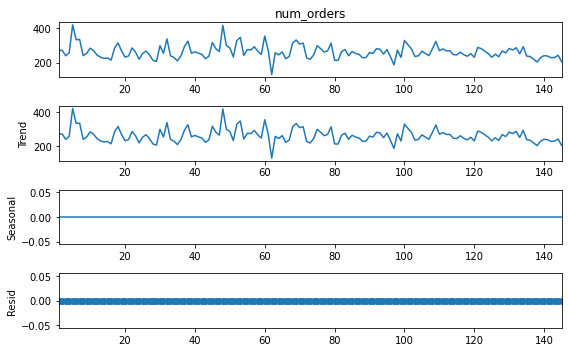

In [64]:
decompose.plot()
plt.show()

In [65]:
decompose = sm.tsa.seasonal_decompose(x=dat['checkout_price'],model='additive',period=1)

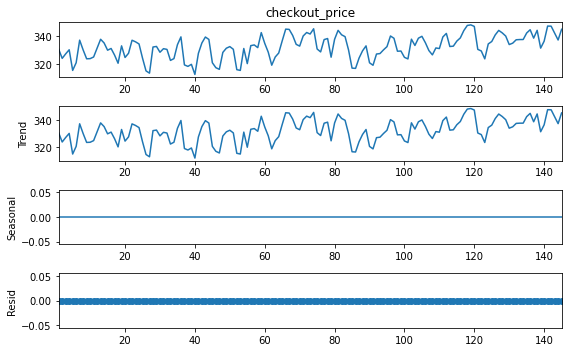

In [66]:
decompose.plot()
plt.show()

In [67]:
decompose = sm.tsa.seasonal_decompose(x=dat['homepage_featured'],model='additive',period=1)

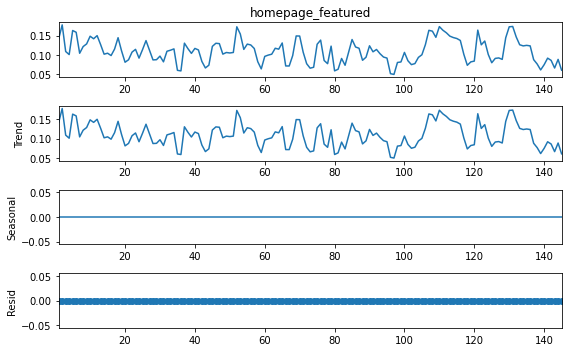

In [68]:
decompose.plot()
plt.show()

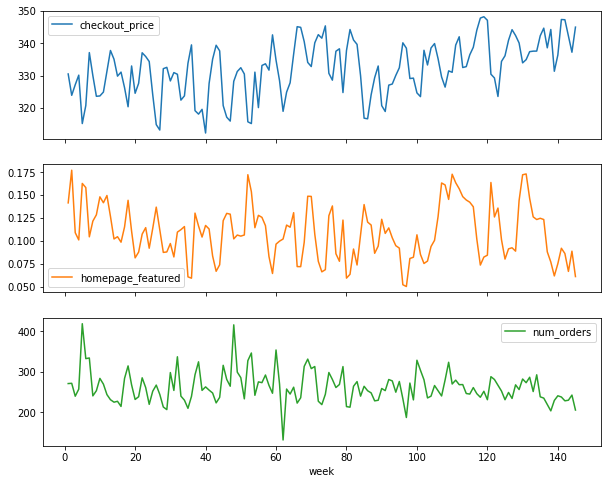

In [69]:
dat.plot(subplots=True,figsize=(10, 8))
plt.show()

In [70]:
for name, column in dat[['checkout_price','homepage_featured','num_orders']].iteritems():
    Augmented_Dickey_Fuller_Test_func(data1[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: checkout_price
Test Statistic                  -3.957556
p-value                          0.001650
No Lags Used                     0.000000
Number of Observations Used    144.000000
Critical Value (1%)             -3.476598
Critical Value (5%)             -2.881829
Critical Value (10%)            -2.577589
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: homepage_featured
Test Statistic                  -2.352810
p-value                          0.155501
No Lags Used                     9.000000
Number of Observations Used    135.000000
Critical Value (1%)             -3.479743
Critical Value (5%)             -2.883198
Critical Value (10%)            -2.578320
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Results of Dickey-Fuller Test for column: num_orders
Test Statistic                  -1.978911
p-value                     

In [71]:
X = dat[['checkout_price','homepage_featured','num_orders']]
train, test = X[0:-15], X[-15:]

In [72]:
train_diff = train.diff()
train_diff.dropna(inplace = True)

In [73]:
for name, column in train_diff[['checkout_price', 'homepage_featured','num_orders',]].iteritems():
    Augmented_Dickey_Fuller_Test_func(train_diff[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: checkout_price
Test Statistic                -8.952080e+00
p-value                        8.669145e-15
No Lags Used                   5.000000e+00
Number of Observations Used    1.230000e+02
Critical Value (1%)           -3.484667e+00
Critical Value (5%)           -2.885340e+00
Critical Value (10%)          -2.579463e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: homepage_featured
Test Statistic                  -5.251102
p-value                          0.000007
No Lags Used                    13.000000
Number of Observations Used    115.000000
Critical Value (1%)             -3.488535
Critical Value (5%)             -2.887020
Critical Value (10%)            -2.580360
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: num_orders
Test Statistic                -6.373518e+00
p-value                 

In [74]:
cointegration_test(train_diff[['checkout_price','homepage_featured','num_orders']])

Column Name   >  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
checkout_price >  146.14    > 24.2761   =>   True
homepage_featured >  69.96     > 12.3212   =>   True
num_orders >  17.36     > 4.1296    =>   True


In [75]:
exo=train_diff[['checkout_price','homepage_featured']]

In [76]:
pq = []
for name, column in train_diff[[ 'checkout_price' ,'homepage_featured', 'num_orders']].iteritems():
    print(f'Searching order of p and q for : {name}')
    stepwise_model = auto_arima(train_diff[name],start_p=1, start_q=1,max_p=7, max_q=7, seasonal=True, X=exo, D=4,max_D=12,
        trace=True,error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=10000)
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : checkout_price
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-2721.245, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-2725.249, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-2723.247, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-2723.242, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-2727.249, Time=0.09 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.651 seconds
optimal order for:checkout_price is: (0, 0, 0) 


Searching order of p and q for : homepage_featured
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-2721.249, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-2725.249, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-2723.249, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-2723.249, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-2727.249, Time=0.08 sec

Best model:  ARIM

In [77]:
pq

[(0, 0, 0), (0, 0, 0), (4, 0, 0)]

In [78]:
df_results = pd.DataFrame(columns=['p', 'q','checkout_price', 'homepage_featured','num_orders' ])
print('Grid Search Started')
start = timer()
for i in pq:
    if i[0]== 0 and i[2] ==0:
        pass
    else:
        print(f' Running for {i}')
        model = VARMAX(train_diff[[  'checkout_price', 'homepage_featured','num_orders'  ]], order=(i[0],i[2])).fit( disp=False)
        result = model.forecast(steps = 15)
        inv_res = inverse_diff(dat[['checkout_price', 'homepage_featured','num_orders'  ]] , result)
        pricerms = np.sqrt(metrics.mean_squared_error(test['checkout_price'], inv_res.checkout_price_1st_inv_diff))
        homerms = np.sqrt(metrics.mean_squared_error(test['homepage_featured'], inv_res.num_orders_1st_inv_diff))
        orderrms = np.sqrt(metrics.mean_squared_error(test['num_orders'], inv_res.num_orders_1st_inv_diff))
        df_results = df_results.append({'p': i[0], 'q': i[2], 'RMSE price':pricerms,'RMSE baseprice':basepricerms,'RMSE order':orderrms,'RMSE promo':promorms,'RMSE feat':homerms}, ignore_index=True)
end = timer()
print(f' Total time taken to complete grid search in seconds: {(end - start)}')


Grid Search Started
 Running for (4, 0, 0)
 Total time taken to complete grid search in seconds: 6.441447874000005


In [79]:
df_results.sort_values(by = ['checkout_price','homepage_featured','num_orders'] )

,p,q,checkout_price,homepage_featured,num_orders,RMSE baseprice,RMSE feat,RMSE order,RMSE price,RMSE promo
0,4.0,0.0,NaN,NaN,NaN,204.046159,182.25402,65.103283,10.162196,92.48067


In [80]:
model = VARMAX(train_diff[[ 'checkout_price','homepage_featured','num_orders' ]], order=(4,0)).fit( disp=False)
result = model.forecast(steps = 15)

In [81]:
res = inverse_diff(dat[[ 'checkout_price','homepage_featured','num_orders']],result)

In [82]:
res

,checkout_price,homepage_featured,num_orders,checkout_price_1st_inv_diff,homepage_featured_1st_inv_diff,num_orders_1st_inv_diff
129,3.099643,-0.029933,-29.195084,348.115555,0.030960,176.412627
130,1.756932,-0.008268,-8.506740,349.872486,0.022692,167.905887
131,-1.669221,0.005014,24.349694,348.203265,0.027706,192.255581
132,2.175324,-0.000196,-10.341276,350.378589,0.027510,181.914305
133,-0.523862,0.003729,2.216944,349.854727,0.031239,184.131249
134,-0.722042,-0.001471,-1.986533,349.132685,0.029768,182.144716
135,0.519518,-0.001079,-3.719013,349.652204,0.028689,178.425703
136,-0.870428,0.002960,8.850712,348.781776,0.031649,187.276414
137,0.341700,-0.000320,-2.232180,349.123475,0.031329,185.044234
138,0.644697,-0.001135,-3.198250,349.768172,0.030194,181.845984


In [83]:
for i in ['checkout_price','homepage_featured','num_orders']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(test[str(i)] , res[str(i)+'_1st_inv_diff'])

Evaluation metric for checkout_price
Evaluation metric results:-
MSE is : 103.27022210494822
MAE is : 9.090644195554416
RMSE is : 10.162195732465904
MAPE is : 2.689897547979088
R2 is : -3.791304077687065

Evaluation metric for homepage_featured
Evaluation metric results:-
MSE is : 0.0061909037182683035
MAE is : 0.07112725501020664
RMSE is : 0.07868229609174038
MAPE is : 67.04792483345344
R2 is : -4.89505912457928

Evaluation metric for num_orders
Evaluation metric results:-
MSE is : 4238.43750711666
MAE is : 58.73336367774214
RMSE is : 65.1032833819974
MAPE is : 23.47767554731737
R2 is : -5.674573069566874



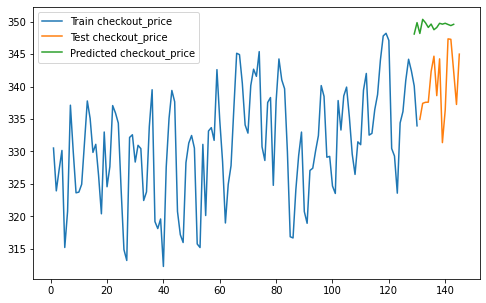

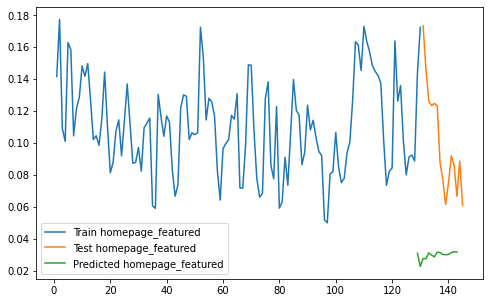

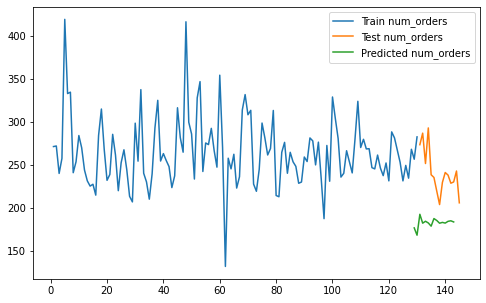

In [84]:
import matplotlib.pyplot as plt
%matplotlib inline
for i in ['checkout_price' ,'homepage_featured', 'num_orders',]:
    
    plt.rcParams["figure.figsize"] = [8,5]
    plt.plot( train[str(i)], label='Train '+str(i))
    plt.plot(test[str(i)], label='Test '+str(i))
    plt.plot(res[str(i)+'_1st_inv_diff'], label='Predicted '+str(i))
    plt.legend(loc='best')
    plt.show()

Still not getting good result

In [85]:
dat

,checkout_price,homepage_featured,num_orders
week,,,
1,330.530205,0.141684,271.136550
2,323.926944,0.177486,271.783149
3,327.202580,0.109003,239.828217
4,330.160502,0.101073,257.365524
5,315.194676,0.162994,419.263729
...,...,...,...
141,347.367882,0.091940,237.891511
142,347.298610,0.086164,228.431439
143,342.346188,0.066566,229.932224


In [86]:
X = dat[['checkout_price','homepage_featured','num_orders']]
train, test = X[0:-5], X[-5:]

In [87]:
train_diff = train.diff()
train_diff.dropna(inplace = True)

In [88]:
exo=train_diff[['checkout_price','homepage_featured']]

In [89]:
pq = []
for name, column in train_diff[[ 'checkout_price' ,'homepage_featured', 'num_orders']].iteritems():
    print(f'Searching order of p and q for : {name}')
    stepwise_model = auto_arima(train_diff[name],start_p=1, start_q=1,max_p=7, max_q=7, seasonal=True, X=exo, D=4,max_D=12,
        trace=True,error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=10000)
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : checkout_price
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-2933.126, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-2937.128, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-2935.127, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-2935.124, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-2939.128, Time=0.09 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.578 seconds
optimal order for:checkout_price is: (0, 0, 0) 


Searching order of p and q for : homepage_featured
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-2933.128, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-2937.128, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-2935.128, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-2935.128, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-2939.128, Time=0.10 sec

Best model:  ARIM

In [90]:
df_results = pd.DataFrame(columns=['p', 'q','checkout_price', 'homepage_featured','num_orders' ])
print('Grid Search Started')
start = timer()
for i in pq:
    if i[0]== 0 and i[2] ==0:
        pass
    else:
        print(f' Running for {i}')
        model = VARMAX(train_diff[[  'checkout_price', 'homepage_featured','num_orders'  ]], order=(i[0],i[2])).fit( disp=False)
        result = model.forecast(steps = 5)
        inv_res = inverse_diff(dat[['checkout_price', 'homepage_featured','num_orders'  ]] , result)
        pricerms = np.sqrt(metrics.mean_squared_error(test['checkout_price'], inv_res.checkout_price_1st_inv_diff))
        homerms = np.sqrt(metrics.mean_squared_error(test['homepage_featured'], inv_res.num_orders_1st_inv_diff))
        orderrms = np.sqrt(metrics.mean_squared_error(test['num_orders'], inv_res.num_orders_1st_inv_diff))
        df_results = df_results.append({'p': i[0], 'q': i[2], 'RMSE price':pricerms,'RMSE baseprice':basepricerms,'RMSE order':orderrms,'RMSE promo':promorms,'RMSE feat':homerms}, ignore_index=True)
end = timer()
print(f' Total time taken to complete grid search in seconds: {(end - start)}')


Grid Search Started
 Running for (0, 0, 1)
 Total time taken to complete grid search in seconds: 3.5080322050000063


In [91]:
df_results.sort_values(by = ['checkout_price','homepage_featured','num_orders'] )

,p,q,checkout_price,homepage_featured,num_orders,RMSE baseprice,RMSE feat,RMSE order,RMSE price,RMSE promo
0,0.0,1.0,NaN,NaN,NaN,204.046159,197.148123,34.082742,4.337129,92.48067


In [92]:
model = VARMAX(train_diff[[ 'checkout_price','homepage_featured','num_orders' ]], order=(0,1)).fit( disp=False)
result = model.forecast(steps = 5)

In [93]:
res = inverse_diff(dat[[ 'checkout_price','homepage_featured','num_orders']],result)

In [94]:
res

,checkout_price,homepage_featured,num_orders,checkout_price_1st_inv_diff,homepage_featured_1st_inv_diff,num_orders_1st_inv_diff
139,0.823458,-0.005750,-7.945995,345.839370,0.055144,197.661716
140,0.042273,-0.000751,-0.217481,345.881643,0.054393,197.444236
141,0.042273,-0.000751,-0.217481,345.923915,0.053642,197.226755
142,0.042273,-0.000751,-0.217481,345.966188,0.052891,197.009274
143,0.042273,-0.000751,-0.217481,346.008461,0.052140,196.791794


In [95]:
for i in ['checkout_price','homepage_featured','num_orders']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(test[str(i)] , res[str(i)+'_1st_inv_diff'])

Evaluation metric for checkout_price
Evaluation metric results:-
MSE is : 18.810688320832867
MAE is : 3.245838988791877
RMSE is : 4.337129041293661
MAPE is : 0.9528839163071564
R2 is : -0.31704038598173323

Evaluation metric for homepage_featured
Evaluation metric results:-
MSE is : 0.0007783590732532189
MAE is : 0.025217811897814784
RMSE is : 0.027899087319359014
MAPE is : 30.216116958557677
R2 is : -3.8899453768730314

Evaluation metric for num_orders
Evaluation metric results:-
MSE is : 1161.6333233399175
MAE is : 31.673804999694113
RMSE is : 34.08274230956068
MAPE is : 13.558759836457156
R2 is : -6.140179251706981



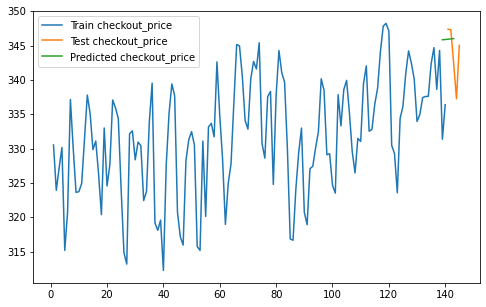

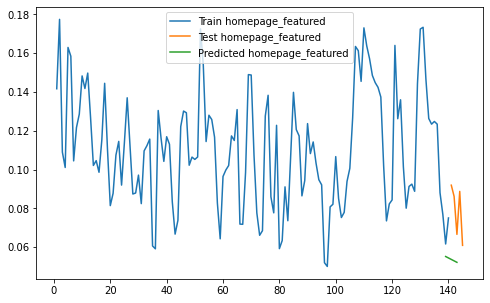

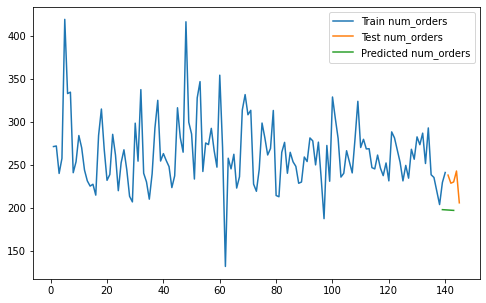

In [96]:
import matplotlib.pyplot as plt
%matplotlib inline
for i in ['checkout_price' ,'homepage_featured', 'num_orders',]:
    
    plt.rcParams["figure.figsize"] = [8,5]
    plt.plot( train[str(i)], label='Train '+str(i))
    plt.plot(test[str(i)], label='Test '+str(i))
    plt.plot(res[str(i)+'_1st_inv_diff'], label='Predicted '+str(i))
    plt.legend(loc='best')
    plt.show()

In [97]:
dat

,checkout_price,homepage_featured,num_orders
week,,,
1,330.530205,0.141684,271.136550
2,323.926944,0.177486,271.783149
3,327.202580,0.109003,239.828217
4,330.160502,0.101073,257.365524
5,315.194676,0.162994,419.263729
...,...,...,...
141,347.367882,0.091940,237.891511
142,347.298610,0.086164,228.431439
143,342.346188,0.066566,229.932224


In [98]:
ts=dat['num_orders']

In [99]:
ts=pd.DataFrame(ts)

In [100]:
ts

,num_orders
week,
1,271.136550
2,271.783149
3,239.828217
4,257.365524
5,419.263729
...,...
141,237.891511
142,228.431439
143,229.932224


In [101]:
train = ts.iloc[:138]
test = ts.iloc[138:]

In [102]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [103]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [104]:
scaled_train[:10]

array([[0.48522865],
       [0.48747571],
       [0.37642598],
       [0.43737161],
       [1.        ],
       [0.69969136],
       [0.70527442],
       [0.37936554],
       [0.4236386 ],
       [0.52977246]])

In [105]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [106]:
# We do the same thing, but now instead for 12 months
n_input = 12
n_features=1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [107]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.48522865 0.48747571 0.37642598 0.43737161 1.         0.69969136
 0.70527442 0.37936554 0.4236386  0.52977246 0.48032606 0.39030384]
Predict this y: 
 [[0.34638783]]


In [108]:
X.shape

(1, 12, 1)

In [109]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [110]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

2022-12-22 07:29:02.113127: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 07:29:02.114215: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 07:29:02.262515: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 07:29:02.263402: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 07:29:02.264212: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [111]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [112]:
# fit model
model.fit(generator,epochs=35)

Epoch 1/35


2022-12-22 07:29:05.986626: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


126/126 [==============================] - 6s 26ms/step - loss: 0.0316
Epoch 2/35
126/126 [==============================] - 3s 24ms/step - loss: 0.0190
Epoch 3/35
126/126 [==============================] - 3s 24ms/step - loss: 0.0189
Epoch 4/35
126/126 [==============================] - 3s 26ms/step - loss: 0.0185
Epoch 5/35
126/126 [==============================] - 3s 23ms/step - loss: 0.0180
Epoch 6/35
126/126 [==============================] - 3s 25ms/step - loss: 0.0176
Epoch 7/35
126/126 [==============================] - 3s 26ms/step - loss: 0.0178
Epoch 8/35
126/126 [==============================] - 3s 24ms/step - loss: 0.0180
Epoch 9/35
126/126 [==============================] - 3s 23ms/step - loss: 0.0164
Epoch 10/35
126/126 [==============================] - 3s 23ms/step - loss: 0.0180
Epoch 11/35
126/126 [==============================] - 3s 26ms/step - loss: 0.0178
Epoch 12/35
126/126 [==============================] - 3s 24ms/step - loss: 0.0195
Epoch 13/35
126/126 [===

In [114]:
last_train_batch = scaled_train[-12:]

In [115]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [116]:
model.predict(last_train_batch)

array([[0.40744105]], dtype=float32)

In [118]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [119]:
test_predictions

[array([0.40744105], dtype=float32),
 array([0.44679534], dtype=float32),
 array([0.44771385], dtype=float32),
 array([0.44745404], dtype=float32),
 array([0.44576734], dtype=float32),
 array([0.44522423], dtype=float32),
 array([0.4433754], dtype=float32)]

In [120]:
test.head()

,num_orders
week,
139,229.318390
140,240.903061
141,237.891511
142,228.431439
143,229.932224


In [121]:
true_predictions = scaler.inverse_transform(test_predictions)

In [122]:
test['Predictions'] = true_predictions

<AxesSubplot:xlabel='week'>

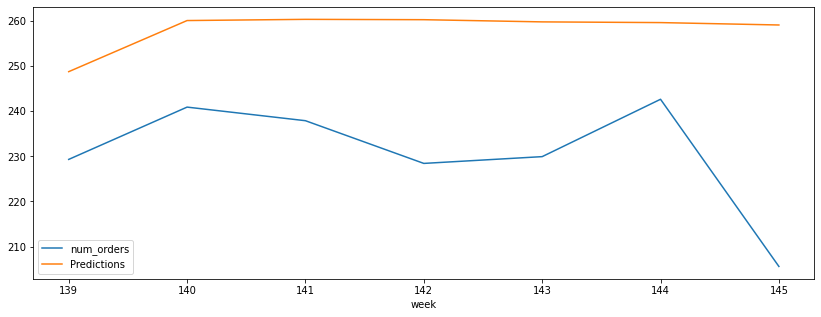

In [123]:
test.plot(figsize=(14,5))

In [124]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(dat['num_orders'][138:145],test['Predictions']))
print(rmse)

30.007155868246226


In [127]:
scaled_train[-4:]

array([[0.37112546],
       [0.36014388],
       [0.30485146],
       [0.25046446]])

In [128]:
dat

,checkout_price,homepage_featured,num_orders
week,,,
1,330.530205,0.141684,271.136550
2,323.926944,0.177486,271.783149
3,327.202580,0.109003,239.828217
4,330.160502,0.101073,257.365524
5,315.194676,0.162994,419.263729
...,...,...,...
141,347.367882,0.091940,237.891511
142,347.298610,0.086164,228.431439
143,342.346188,0.066566,229.932224


In [129]:
lag_features = ['checkout_price','homepage_featured','num_orders']
dat_rolled_7d = dat[lag_features].rolling(window=7, min_periods=0)
dat_mean_7d = dat_rolled_7d.mean().shift(1).reset_index().astype(np.float32)

In [130]:
exo

,checkout_price,homepage_featured
week,,
2,-6.603261,0.035802
3,3.275636,-0.068483
4,2.957922,-0.007930
5,-14.965825,0.061921
6,5.578342,-0.004526
...,...,...
136,2.359705,-0.001374
137,-6.082116,-0.035405
138,5.670916,-0.011153


In [131]:
exo=['checkout_price',	'homepage_featured']

In [132]:
train=dat[:-10]

In [133]:
train

,checkout_price,homepage_featured,num_orders
week,,,
1,330.530205,0.141684,271.136550
2,323.926944,0.177486,271.783149
3,327.202580,0.109003,239.828217
4,330.160502,0.101073,257.365524
5,315.194676,0.162994,419.263729
...,...,...,...
131,334.959672,0.173398,273.292742
132,337.430256,0.146520,286.744200
133,337.585806,0.126354,251.378761


In [134]:
test=dat[135:]

In [135]:
test

,checkout_price,homepage_featured,num_orders
week,,,
136,344.696746,0.123434,235.142988
137,338.614630,0.088029,219.232409
138,344.285546,0.076876,203.582367
139,331.366572,0.061604,229.318390
140,336.392530,0.075030,240.903061
141,347.367882,0.091940,237.891511
142,347.298610,0.086164,228.431439
143,342.346188,0.066566,229.932224
144,337.252750,0.088734,242.639915


In [136]:
from pmdarima import auto_arima
model = auto_arima(
	train["num_orders"],
	exogenous=train[exo],
	trace=True,
	error_action="ignore",
	suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1373.773, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1374.939, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1369.833, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1368.854, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1893.988, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1371.087, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1370.836, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1372.822, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1748.676, Time=0.07 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 1.007 seconds


In [137]:
forecast = model.predict(n_periods=len(test),  exogenous=test[exo])

In [138]:
forecast

135    255.789120
136    264.429827
137    264.429827
138    264.429827
139    264.429827
140    264.429827
141    264.429827
142    264.429827
143    264.429827
144    264.429827
dtype: float64

In [139]:
test

,checkout_price,homepage_featured,num_orders
week,,,
136,344.696746,0.123434,235.142988
137,338.614630,0.088029,219.232409
138,344.285546,0.076876,203.582367
139,331.366572,0.061604,229.318390
140,336.392530,0.075030,240.903061
141,347.367882,0.091940,237.891511
142,347.298610,0.086164,228.431439
143,342.346188,0.066566,229.932224
144,337.252750,0.088734,242.639915


In [140]:
rmse=sqrt(mean_squared_error(forecast,test['num_orders']))
print(rmse)

38.83670481492248


In [141]:
test['num_orders']

week
136    235.142988
137    219.232409
138    203.582367
139    229.318390
140    240.903061
141    237.891511
142    228.431439
143    229.932224
144    242.639915
145    205.607711
Name: num_orders, dtype: float64

In [142]:
forecast

135    255.789120
136    264.429827
137    264.429827
138    264.429827
139    264.429827
140    264.429827
141    264.429827
142    264.429827
143    264.429827
144    264.429827
dtype: float64

In [143]:
master=pd.read_csv('/kaggle/input/demand/master_data.csv')

In [144]:
master.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,TYPE_C,2.0,Beverages,Thai
1,1466964,1,55,1993,136.83,135.83,0,0,270,647,56,TYPE_C,2.0,Beverages,Thai
2,1346989,1,55,2539,134.86,135.86,0,0,189,647,56,TYPE_C,2.0,Beverages,Thai
3,1338232,1,55,2139,339.50,437.53,0,0,54,647,56,TYPE_C,2.0,Beverages,Indian
4,1448490,1,55,2631,243.50,242.50,0,0,40,647,56,TYPE_C,2.0,Beverages,Indian


In [145]:
master=master.drop(columns=['center_id','meal_id','id'])

In [146]:
master.head()

,week,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine
0,1,136.83,152.29,0,0,177,647,56,TYPE_C,2.0,Beverages,Thai
1,1,136.83,135.83,0,0,270,647,56,TYPE_C,2.0,Beverages,Thai
2,1,134.86,135.86,0,0,189,647,56,TYPE_C,2.0,Beverages,Thai
3,1,339.50,437.53,0,0,54,647,56,TYPE_C,2.0,Beverages,Indian
4,1,243.50,242.50,0,0,40,647,56,TYPE_C,2.0,Beverages,Indian


In [147]:
master=master.groupby(['week','city_code','region_code','center_type','op_area','category','cuisine']).mean()

In [148]:
master.head()

checkout_price  \
week city_code region_code center_type op_area category  cuisine                       
1    456       56          TYPE_A      4.2     Beverages Continental      329.830000   
                                                         Indian           281.986667   
                                                         Italian          186.593333   
                                                         Thai             134.526667   
                                               Biryani   Indian           371.863333   

                                                                      base_price  \
week city_code region_code center_type op_area category  cuisine                   
1    456       56          TYPE_A      4.2     Beverages Continental  394.486667   
                                                         Indian       313.330000   
                                                         Italian      175.590000   
                                                         Thai         135.183333   
                                               Biryani   Indian       458.830000   

                                                                      emailer_for_promotion  \
week city_code region_code center_type op_area category  cuisine                              
1    456       56          TYPE_A      4.2     Beverages Continental                    0.0   
                                                         Indian                         0.0   
                                                         Italian                        0.0   
                                                         Thai                           0.0   
                                               Biryani   Indian                         0.0   

                                                                      homepage_featured  \
week city_code region_code center_type op_area category  cuisine                          
1    456       56          TYPE_A      4.2     Beverages Continental           0.666667   
                                                         Indian                0.000000   
                                                         Italian               0.333333   
                                                         Thai                  0.666667   
                                               Biryani   Indian                0.000000   

                                                                      num_orders  
week city_code region_code center_type op_area category  cuisine                  
1    456       56          TYPE_A      4.2     Beverages Continental  243.000000  
                                                         Indian        44.666667  
                                                         Italian      635.000000  
                                                         Thai         882.333333  
                                               Biryani   Indian        49.333333

In [150]:
master

checkout_price  \
week city_code region_code center_type op_area category  cuisine                       
1    456       56          TYPE_A      4.2     Beverages Continental      329.830000   
                                                         Indian           281.986667   
                                                         Italian          186.593333   
                                                         Thai             134.526667   
                                               Biryani   Indian           371.863333   
...                                                                              ...   
145  713       85          TYPE_A      4.5     Salad     Italian          253.876667   
                                               Sandwich  Italian          345.986667   
                                               Seafood   Continental      707.483333   
                                               Soup      Thai             196.000000   
                                               Starters  Thai             319.463333   

                                                                      base_price  \
week city_code region_code center_type op_area category  cuisine                   
1    456       56          TYPE_A      4.2     Beverages Continental  394.486667   
                                                         Indian       313.330000   
                                                         Italian      175.590000   
                                                         Thai         135.183333   
                                               Biryani   Indian       458.830000   
...                                                                          ...   
145  713       85          TYPE_A      4.5     Salad     Italian      322.383333   
                                               Sandwich  Italian      346.653333   
                                               Seafood   Continental  707.150000   
                                               Soup      Thai         195.333333   
                                               Starters  Thai         320.463333   

                                                                      emailer_for_promotion  \
week city_code region_code center_type op_area category  cuisine                              
1    456       56          TYPE_A      4.2     Beverages Continental                    0.0   
                                                         Indian                         0.0   
                                                         Italian                        0.0   
                                                         Thai                           0.0   
                                               Biryani   Indian                         0.0   
...                                                                                     ...   
145  713       85          TYPE_A      4.5     Salad     Italian                        0.0   
                                               Sandwich  Italian                        0.0   
                                               Seafood   Continental                    0.0   
                                               Soup      Thai                           0.0   
                                               Starters  Thai                           0.0   

                                                                      homepage_featured  \
week city_code region_code center_type op_area category  cuisine                          
1    456       56          TYPE_A      4.2     Beverages Continental           0.666667   
                                                         Indian                0.000000   
                                                         Italian               0.333333   
                                                         Thai                  0.666667   
                                               Bir

In [151]:
for name, column in master[['checkout_price','base_price','emailer_for_promotion','homepage_featured','num_orders']].iteritems():
    Augmented_Dickey_Fuller_Test_func(data1[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: checkout_price
Test Statistic                  -3.957556
p-value                          0.001650
No Lags Used                     0.000000
Number of Observations Used    144.000000
Critical Value (1%)             -3.476598
Critical Value (5%)             -2.881829
Critical Value (10%)            -2.577589
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: base_price
Test Statistic                  -2.793651
p-value                          0.059186
No Lags Used                    10.000000
Number of Observations Used    134.000000
Critical Value (1%)             -3.480119
Critical Value (5%)             -2.883362
Critical Value (10%)            -2.578407
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Results of Dickey-Fuller Test for column: emailer_for_promotion
Test Statistic                  -4.831512
p-value                 

In [152]:
master[['checkout_price','base_price','emailer_for_promotion','homepage_featured','num_orders']]

checkout_price  \
week city_code region_code center_type op_area category  cuisine                       
1    456       56          TYPE_A      4.2     Beverages Continental      329.830000   
                                                         Indian           281.986667   
                                                         Italian          186.593333   
                                                         Thai             134.526667   
                                               Biryani   Indian           371.863333   
...                                                                              ...   
145  713       85          TYPE_A      4.5     Salad     Italian          253.876667   
                                               Sandwich  Italian          345.986667   
                                               Seafood   Continental      707.483333   
                                               Soup      Thai             196.000000   
                                               Starters  Thai             319.463333   

                                                                      base_price  \
week city_code region_code center_type op_area category  cuisine                   
1    456       56          TYPE_A      4.2     Beverages Continental  394.486667   
                                                         Indian       313.330000   
                                                         Italian      175.590000   
                                                         Thai         135.183333   
                                               Biryani   Indian       458.830000   
...                                                                          ...   
145  713       85          TYPE_A      4.5     Salad     Italian      322.383333   
                                               Sandwich  Italian      346.653333   
                                               Seafood   Continental  707.150000   
                                               Soup      Thai         195.333333   
                                               Starters  Thai         320.463333   

                                                                      emailer_for_promotion  \
week city_code region_code center_type op_area category  cuisine                              
1    456       56          TYPE_A      4.2     Beverages Continental                    0.0   
                                                         Indian                         0.0   
                                                         Italian                        0.0   
                                                         Thai                           0.0   
                                               Biryani   Indian                         0.0   
...                                                                                     ...   
145  713       85          TYPE_A      4.5     Salad     Italian                        0.0   
                                               Sandwich  Italian                        0.0   
                                               Seafood   Continental                    0.0   
                                               Soup      Thai                           0.0   
                                               Starters  Thai                           0.0   

                                                                      homepage_featured  \
week city_code region_code center_type op_area category  cuisine                          
1    456       56          TYPE_A      4.2     Beverages Continental           0.666667   
                                                         Indian                0.000000   
                                                         Italian               0.333333   
                                                         Thai                  0.666667   
                                               Bir

In [153]:
master=pd.read_csv('/kaggle/input/demand/master_data.csv')

In [154]:
master=master.drop(columns=['center_id','meal_id','id','city_code'])

<AxesSubplot:>

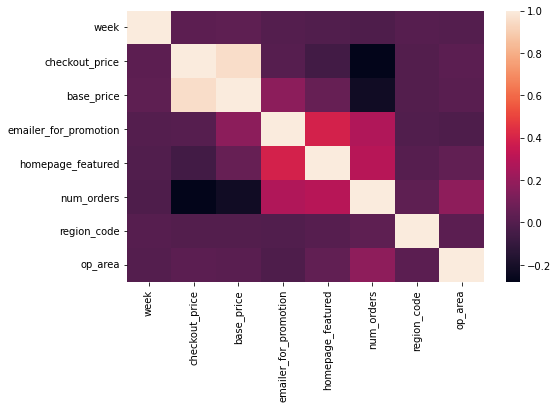

In [155]:
corr=master.corr()
sns.heatmap(corr)

In [156]:
master=master.drop(columns=['homepage_featured','base_price'])

In [157]:
master=pd.get_dummies(master,columns=['region_code','center_type','category','cuisine'])

In [158]:
master

,week,checkout_price,emailer_for_promotion,num_orders,op_area,region_code_23,region_code_34,region_code_35,region_code_56,region_code_71,...,category_Rice Bowl,category_Salad,category_Sandwich,category_Seafood,category_Soup,category_Starters,cuisine_Continental,cuisine_Indian,cuisine_Italian,cuisine_Thai
0,1,136.83,0,177,2.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1,136.83,0,270,2.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,1,134.86,0,189,2.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,1,339.50,0,54,2.0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,1,243.50,0,40,2.0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456543,145,484.09,0,68,4.5,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
456544,145,482.09,0,42,4.5,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
456545,145,237.68,0,501,4.5,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
456546,145,243.50,0,729,4.5,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0


In [159]:
master=master.groupby(['week']).mean()

In [160]:
master

,checkout_price,emailer_for_promotion,num_orders,op_area,region_code_23,region_code_34,region_code_35,region_code_56,region_code_71,region_code_77,...,category_Rice Bowl,category_Salad,category_Sandwich,category_Seafood,category_Soup,category_Starters,cuisine_Continental,cuisine_Indian,cuisine_Italian,cuisine_Thai
week,,,,,,,,,,,,,,,,,,,,,
1,330.530205,0.122177,271.136550,4.079877,0.015058,0.253936,0.011636,0.417864,0.013005,0.207392,...,0.079055,0.000000,0.078713,0.056810,0.027036,0.071526,0.211499,0.280630,0.230322,0.277550
2,323.926944,0.214434,271.783149,4.085014,0.014503,0.252072,0.012086,0.421271,0.013467,0.204765,...,0.079420,0.000000,0.079075,0.058011,0.028315,0.072859,0.214088,0.274517,0.230663,0.280732
3,327.202580,0.035874,239.828217,4.078682,0.014143,0.253536,0.011728,0.419800,0.013108,0.206278,...,0.079683,0.000000,0.079338,0.057606,0.028286,0.071749,0.212487,0.275957,0.231459,0.280097
4,330.160502,0.000000,257.365524,4.087747,0.015230,0.250952,0.012461,0.422638,0.013846,0.205607,...,0.079958,0.000000,0.079612,0.058844,0.029422,0.074074,0.214953,0.273105,0.226376,0.285566
5,315.194676,0.117873,419.263729,4.077824,0.014341,0.259531,0.012242,0.420427,0.013641,0.210213,...,0.079748,0.000000,0.079398,0.066107,0.027632,0.073102,0.220707,0.272823,0.225603,0.280867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,347.367882,0.070794,237.891511,4.091603,0.014097,0.256512,0.010420,0.414956,0.014404,0.208704,...,0.070794,0.070794,0.070487,0.046889,0.027276,0.060680,0.229543,0.244560,0.273062,0.252835
142,347.298610,0.071340,228.431439,4.097468,0.013589,0.254169,0.011427,0.420012,0.014515,0.205991,...,0.071340,0.071340,0.071340,0.047869,0.028104,0.062384,0.229771,0.245831,0.269302,0.255096
143,342.346188,0.022995,229.932224,4.077186,0.014221,0.253858,0.011195,0.417247,0.014523,0.208775,...,0.069894,0.069894,0.069894,0.065356,0.028442,0.062935,0.245386,0.237519,0.263238,0.253858


In [161]:
master.head()

,checkout_price,emailer_for_promotion,num_orders,op_area,region_code_23,region_code_34,region_code_35,region_code_56,region_code_71,region_code_77,...,category_Rice Bowl,category_Salad,category_Sandwich,category_Seafood,category_Soup,category_Starters,cuisine_Continental,cuisine_Indian,cuisine_Italian,cuisine_Thai
week,,,,,,,,,,,,,,,,,,,,,
1,330.530205,0.122177,271.136550,4.079877,0.015058,0.253936,0.011636,0.417864,0.013005,0.207392,...,0.079055,0.0,0.078713,0.056810,0.027036,0.071526,0.211499,0.280630,0.230322,0.277550
2,323.926944,0.214434,271.783149,4.085014,0.014503,0.252072,0.012086,0.421271,0.013467,0.204765,...,0.079420,0.0,0.079075,0.058011,0.028315,0.072859,0.214088,0.274517,0.230663,0.280732
3,327.202580,0.035874,239.828217,4.078682,0.014143,0.253536,0.011728,0.419800,0.013108,0.206278,...,0.079683,0.0,0.079338,0.057606,0.028286,0.071749,0.212487,0.275957,0.231459,0.280097
4,330.160502,0.000000,257.365524,4.087747,0.015230,0.250952,0.012461,0.422638,0.013846,0.205607,...,0.079958,0.0,0.079612,0.058844,0.029422,0.074074,0.214953,0.273105,0.226376,0.285566
5,315.194676,0.117873,419.263729,4.077824,0.014341,0.259531,0.012242,0.420427,0.013641,0.210213,...,0.079748,0.0,0.079398,0.066107,0.027632,0.073102,0.220707,0.272823,0.225603,0.280867


In [162]:
X = master[['checkout_price', 'emailer_for_promotion', 'op_area', 'region_code_23',
       'region_code_34', 'region_code_35', 'region_code_56', 'region_code_71',
       'region_code_77', 'region_code_85', 'region_code_93',
       'center_type_TYPE_A', 'center_type_TYPE_B', 'center_type_TYPE_C',
       'category_Beverages', 'category_Biryani', 'category_Desert',
       'category_Extras', 'category_Fish', 'category_Other Snacks',
       'category_Pasta', 'category_Pizza', 'category_Rice Bowl',
       'category_Salad', 'category_Sandwich', 'category_Seafood',
       'category_Soup', 'category_Starters', 'cuisine_Continental',
       'cuisine_Indian', 'cuisine_Italian', 'cuisine_Thai','num_orders']]
train, test = X[0:-15], X[-15:]

In [163]:
train_diff = train.diff()
train_diff.dropna(inplace = True)

In [164]:
for name, column in train_diff[['checkout_price', 'emailer_for_promotion', 'op_area', 'region_code_23',
       'region_code_34', 'region_code_35', 'region_code_56', 'region_code_71',
       'region_code_77', 'region_code_85', 'region_code_93',
       'center_type_TYPE_A', 'center_type_TYPE_B', 'center_type_TYPE_C',
       'category_Beverages', 'category_Biryani', 'category_Desert',
       'category_Extras', 'category_Fish', 'category_Other Snacks',
       'category_Pasta', 'category_Pizza', 'category_Rice Bowl',
       'category_Salad', 'category_Sandwich', 'category_Seafood',
       'category_Soup', 'category_Starters', 'cuisine_Continental',
       'cuisine_Indian', 'cuisine_Italian', 'cuisine_Thai','num_orders']].iteritems():
    Augmented_Dickey_Fuller_Test_func(train_diff[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: checkout_price
Test Statistic                -8.952080e+00
p-value                        8.669145e-15
No Lags Used                   5.000000e+00
Number of Observations Used    1.230000e+02
Critical Value (1%)           -3.484667e+00
Critical Value (5%)           -2.885340e+00
Critical Value (10%)          -2.579463e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: emailer_for_promotion
Test Statistic                -8.211123e+00
p-value                        6.814147e-13
No Lags Used                   7.000000e+00
Number of Observations Used    1.210000e+02
Critical Value (1%)           -3.485585e+00
Critical Value (5%)           -2.885739e+00
Critical Value (10%)          -2.579676e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: op_area
Test Statistic                  -5.630150
p-value    

In [170]:
exo=train_diff.drop(columns=['num_orders'])

In [ ]:
pq = []
for name, column in train_diff[['checkout_price', 'emailer_for_promotion', 'op_area', 'region_code_23',
       'region_code_34', 'region_code_35', 'region_code_56', 'region_code_71',
       'region_code_77', 'region_code_85', 'region_code_93',
       'center_type_TYPE_A', 'center_type_TYPE_B', 'center_type_TYPE_C',
       'category_Beverages', 'category_Biryani', 'category_Desert',
       'category_Extras', 'category_Fish', 'category_Other Snacks',
       'category_Pasta', 'category_Pizza', 'category_Rice Bowl',
       'category_Salad', 'category_Sandwich', 'category_Seafood',
       'category_Soup', 'category_Starters', 'cuisine_Continental',
       'cuisine_Indian', 'cuisine_Italian', 'cuisine_Thai','num_orders' ]].iteritems():
    print(f'Searching order of p and q for : {name}')
    stepwise_model = auto_arima(train_diff[name],start_p=1, start_q=1,max_p=7, max_q=7, seasonal=True, X=exo, D=4,max_D=12,
        trace=True,error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=10000)
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : checkout_price
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-2661.246, Time=0.94 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-2665.249, Time=0.38 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-2663.246, Time=0.40 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-2663.246, Time=0.72 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-2667.249, Time=0.37 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 2.843 seconds
optimal order for:checkout_price is: (0, 0, 0) 


Searching order of p and q for : emailer_for_promotion
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-2661.247, Time=0.89 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-2665.249, Time=0.48 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-2663.248, Time=0.42 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-2663.245, Time=0.87 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-2667.249, Time=0.37 sec

Best model:  

In [172]:
pq

[(0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (1, 0, 1)]

In [175]:
master

,checkout_price,emailer_for_promotion,num_orders,op_area,region_code_23,region_code_34,region_code_35,region_code_56,region_code_71,region_code_77,...,category_Rice Bowl,category_Salad,category_Sandwich,category_Seafood,category_Soup,category_Starters,cuisine_Continental,cuisine_Indian,cuisine_Italian,cuisine_Thai
week,,,,,,,,,,,,,,,,,,,,,
1,330.530205,0.122177,271.136550,4.079877,0.015058,0.253936,0.011636,0.417864,0.013005,0.207392,...,0.079055,0.000000,0.078713,0.056810,0.027036,0.071526,0.211499,0.280630,0.230322,0.277550
2,323.926944,0.214434,271.783149,4.085014,0.014503,0.252072,0.012086,0.421271,0.013467,0.204765,...,0.079420,0.000000,0.079075,0.058011,0.028315,0.072859,0.214088,0.274517,0.230663,0.280732
3,327.202580,0.035874,239.828217,4.078682,0.014143,0.253536,0.011728,0.419800,0.013108,0.206278,...,0.079683,0.000000,0.079338,0.057606,0.028286,0.071749,0.212487,0.275957,0.231459,0.280097
4,330.160502,0.000000,257.365524,4.087747,0.015230,0.250952,0.012461,0.422638,0.013846,0.205607,...,0.079958,0.000000,0.079612,0.058844,0.029422,0.074074,0.214953,0.273105,0.226376,0.285566
5,315.194676,0.117873,419.263729,4.077824,0.014341,0.259531,0.012242,0.420427,0.013641,0.210213,...,0.079748,0.000000,0.079398,0.066107,0.027632,0.073102,0.220707,0.272823,0.225603,0.280867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,347.367882,0.070794,237.891511,4.091603,0.014097,0.256512,0.010420,0.414956,0.014404,0.208704,...,0.070794,0.070794,0.070487,0.046889,0.027276,0.060680,0.229543,0.244560,0.273062,0.252835
142,347.298610,0.071340,228.431439,4.097468,0.013589,0.254169,0.011427,0.420012,0.014515,0.205991,...,0.071340,0.071340,0.071340,0.047869,0.028104,0.062384,0.229771,0.245831,0.269302,0.255096
143,342.346188,0.022995,229.932224,4.077186,0.014221,0.253858,0.011195,0.417247,0.014523,0.208775,...,0.069894,0.069894,0.069894,0.065356,0.028442,0.062935,0.245386,0.237519,0.263238,0.253858


In [176]:
master

,checkout_price,emailer_for_promotion,num_orders,op_area,region_code_23,region_code_34,region_code_35,region_code_56,region_code_71,region_code_77,...,category_Rice Bowl,category_Salad,category_Sandwich,category_Seafood,category_Soup,category_Starters,cuisine_Continental,cuisine_Indian,cuisine_Italian,cuisine_Thai
week,,,,,,,,,,,,,,,,,,,,,
1,330.530205,0.122177,271.136550,4.079877,0.015058,0.253936,0.011636,0.417864,0.013005,0.207392,...,0.079055,0.000000,0.078713,0.056810,0.027036,0.071526,0.211499,0.280630,0.230322,0.277550
2,323.926944,0.214434,271.783149,4.085014,0.014503,0.252072,0.012086,0.421271,0.013467,0.204765,...,0.079420,0.000000,0.079075,0.058011,0.028315,0.072859,0.214088,0.274517,0.230663,0.280732
3,327.202580,0.035874,239.828217,4.078682,0.014143,0.253536,0.011728,0.419800,0.013108,0.206278,...,0.079683,0.000000,0.079338,0.057606,0.028286,0.071749,0.212487,0.275957,0.231459,0.280097
4,330.160502,0.000000,257.365524,4.087747,0.015230,0.250952,0.012461,0.422638,0.013846,0.205607,...,0.079958,0.000000,0.079612,0.058844,0.029422,0.074074,0.214953,0.273105,0.226376,0.285566
5,315.194676,0.117873,419.263729,4.077824,0.014341,0.259531,0.012242,0.420427,0.013641,0.210213,...,0.079748,0.000000,0.079398,0.066107,0.027632,0.073102,0.220707,0.272823,0.225603,0.280867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,347.367882,0.070794,237.891511,4.091603,0.014097,0.256512,0.010420,0.414956,0.014404,0.208704,...,0.070794,0.070794,0.070487,0.046889,0.027276,0.060680,0.229543,0.244560,0.273062,0.252835
142,347.298610,0.071340,228.431439,4.097468,0.013589,0.254169,0.011427,0.420012,0.014515,0.205991,...,0.071340,0.071340,0.071340,0.047869,0.028104,0.062384,0.229771,0.245831,0.269302,0.255096
143,342.346188,0.022995,229.932224,4.077186,0.014221,0.253858,0.011195,0.417247,0.014523,0.208775,...,0.069894,0.069894,0.069894,0.065356,0.028442,0.062935,0.245386,0.237519,0.263238,0.253858


In [177]:
cor=master.corr()

In [179]:
cor_matrix = master.corr().abs()
cor_matrix

,checkout_price,emailer_for_promotion,num_orders,op_area,region_code_23,region_code_34,region_code_35,region_code_56,region_code_71,region_code_77,...,category_Rice Bowl,category_Salad,category_Sandwich,category_Seafood,category_Soup,category_Starters,cuisine_Continental,cuisine_Indian,cuisine_Italian,cuisine_Thai
checkout_price,1.000000,0.432289,0.334160,0.319476,0.103270,0.173284,0.135178,0.008646,0.326083,0.234395,...,0.361162,0.184712,0.361421,0.237855,0.220480,0.418224,0.447185,0.283995,0.029046,0.226107
emailer_for_promotion,0.432289,1.000000,0.451582,0.192296,0.051099,0.053686,0.012316,0.012293,0.062732,0.091986,...,0.081618,0.015867,0.074786,0.137046,0.025121,0.016932,0.020435,0.088507,0.041213,0.048316
num_orders,0.334160,0.451582,1.000000,0.349422,0.023059,0.033776,0.022382,0.116527,0.225429,0.150850,...,0.031635,0.078281,0.024217,0.394798,0.006812,0.077221,0.026137,0.166527,0.093381,0.010509
op_area,0.319476,0.192296,0.349422,1.000000,0.076011,0.136792,0.342521,0.018263,0.284218,0.007836,...,0.019171,0.076604,0.030545,0.407873,0.108183,0.115294,0.278334,0.240660,0.192451,0.177877
region_code_23,0.103270,0.051099,0.023059,0.076011,1.000000,0.046413,0.067554,0.139361,0.147234,0.060776,...,0.186273,0.260237,0.182784,0.133070,0.007011,0.233987,0.010693,0.113245,0.233214,0.249303
region_code_34,0.173284,0.053686,0.033776,0.136792,0.046413,1.000000,0.088769,0.340131,0.169139,0.362696,...,0.415030,0.306569,0.411229,0.091245,0.132633,0.388143,0.164753,0.113235,0.184942,0.364104
region_code_35,0.135178,0.012316,0.022382,0.342521,0.067554,0.088769,1.000000,0.041616,0.069848,0.091627,...,0.152131,0.171872,0.147518,0.093007,0.060993,0.166938,0.234258,0.367255,0.072811,0.039861
region_code_56,0.008646,0.012293,0.116527,0.018263,0.139361,0.340131,0.041616,1.000000,0.076169,0.364511,...,0.148288,0.303590,0.151984,0.023251,0.028455,0.235748,0.070860,0.199754,0.306757,0.348020
region_code_71,0.326083,0.062732,0.225429,0.284218,0.147234,0.169139,0.069848,0.076169,1.000000,0.199296,...,0.420639,0.175499,0.403900,0.259895,0.290841,0.467803,0.473604,0.242096,0.007137,0.351480
region_code_77,0.234395,0.091986,0.150850,0.007836,0.060776,0.362696,0.091627,0.364511,0.199296,1.000000,...,0.522492,0.325784,0.524008,0.111544,0.038192,0.450183,0.386070,0.284819,0.112754,0.360970


In [180]:
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
upper_tri

,checkout_price,emailer_for_promotion,num_orders,op_area,region_code_23,region_code_34,region_code_35,region_code_56,region_code_71,region_code_77,...,category_Rice Bowl,category_Salad,category_Sandwich,category_Seafood,category_Soup,category_Starters,cuisine_Continental,cuisine_Indian,cuisine_Italian,cuisine_Thai
checkout_price,NaN,0.432289,0.334160,0.319476,0.103270,0.173284,0.135178,0.008646,0.326083,0.234395,...,0.361162,0.184712,0.361421,0.237855,0.220480,0.418224,0.447185,0.283995,0.029046,0.226107
emailer_for_promotion,NaN,NaN,0.451582,0.192296,0.051099,0.053686,0.012316,0.012293,0.062732,0.091986,...,0.081618,0.015867,0.074786,0.137046,0.025121,0.016932,0.020435,0.088507,0.041213,0.048316
num_orders,NaN,NaN,NaN,0.349422,0.023059,0.033776,0.022382,0.116527,0.225429,0.150850,...,0.031635,0.078281,0.024217,0.394798,0.006812,0.077221,0.026137,0.166527,0.093381,0.010509
op_area,NaN,NaN,NaN,NaN,0.076011,0.136792,0.342521,0.018263,0.284218,0.007836,...,0.019171,0.076604,0.030545,0.407873,0.108183,0.115294,0.278334,0.240660,0.192451,0.177877
region_code_23,NaN,NaN,NaN,NaN,NaN,0.046413,0.067554,0.139361,0.147234,0.060776,...,0.186273,0.260237,0.182784,0.133070,0.007011,0.233987,0.010693,0.113245,0.233214,0.249303
region_code_34,NaN,NaN,NaN,NaN,NaN,NaN,0.088769,0.340131,0.169139,0.362696,...,0.415030,0.306569,0.411229,0.091245,0.132633,0.388143,0.164753,0.113235,0.184942,0.364104
region_code_35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.041616,0.069848,0.091627,...,0.152131,0.171872,0.147518,0.093007,0.060993,0.166938,0.234258,0.367255,0.072811,0.039861
region_code_56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.076169,0.364511,...,0.148288,0.303590,0.151984,0.023251,0.028455,0.235748,0.070860,0.199754,0.306757,0.348020
region_code_71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.199296,...,0.420639,0.175499,0.403900,0.259895,0.290841,0.467803,0.473604,0.242096,0.007137,0.351480
region_code_77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.522492,0.325784,0.524008,0.111544,0.038192,0.450183,0.386070,0.284819,0.112754,0.360970


In [181]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.75)]
print(); 
print(to_drop)


['center_type_TYPE_B', 'category_Fish', 'category_Pizza', 'category_Rice Bowl', 'category_Salad', 'category_Sandwich', 'category_Starters', 'cuisine_Continental', 'cuisine_Indian', 'cuisine_Italian', 'cuisine_Thai']


In [182]:
master=master.drop(columns=['center_type_TYPE_B', 'category_Fish', 'category_Pizza', 'category_Rice Bowl', 'category_Salad', 'category_Sandwich', 'category_Starters', 'cuisine_Continental', 'cuisine_Indian', 'cuisine_Italian', 'cuisine_Thai'])

In [183]:
master

,checkout_price,emailer_for_promotion,num_orders,op_area,region_code_23,region_code_34,region_code_35,region_code_56,region_code_71,region_code_77,...,center_type_TYPE_A,center_type_TYPE_C,category_Beverages,category_Biryani,category_Desert,category_Extras,category_Other Snacks,category_Pasta,category_Seafood,category_Soup
week,,,,,,,,,,,,,,,,,,,,,
1,330.530205,0.122177,271.136550,4.079877,0.015058,0.253936,0.011636,0.417864,0.013005,0.207392,...,0.573922,0.220055,0.303559,0.059890,0.071869,0.032170,0.067762,0.072553,0.056810,0.027036
2,323.926944,0.214434,271.783149,4.085014,0.014503,0.252072,0.012086,0.421271,0.013467,0.204765,...,0.576312,0.215815,0.305939,0.054903,0.070097,0.032113,0.067680,0.072169,0.058011,0.028315
3,327.202580,0.035874,239.828217,4.078682,0.014143,0.253536,0.011728,0.419800,0.013108,0.206278,...,0.575371,0.219041,0.304933,0.057606,0.069334,0.032080,0.068644,0.072439,0.057606,0.028286
4,330.160502,0.000000,257.365524,4.087747,0.015230,0.250952,0.012461,0.422638,0.013846,0.205607,...,0.582208,0.213915,0.305296,0.053652,0.070613,0.033229,0.068882,0.066805,0.058844,0.029422
5,315.194676,0.117873,419.263729,4.077824,0.014341,0.259531,0.012242,0.420427,0.013641,0.210213,...,0.583771,0.224554,0.302204,0.053865,0.072403,0.033228,0.068206,0.066457,0.066107,0.027632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,347.367882,0.070794,237.891511,4.091603,0.014097,0.256512,0.010420,0.414956,0.014404,0.208704,...,0.572479,0.215752,0.275513,0.042599,0.067116,0.030647,0.063439,0.060987,0.046889,0.027276
142,347.298610,0.071340,228.431439,4.097468,0.013589,0.254169,0.011427,0.420012,0.014515,0.205991,...,0.577208,0.210006,0.277949,0.043545,0.064855,0.029339,0.064237,0.055281,0.047869,0.028104
143,342.346188,0.022995,229.932224,4.077186,0.014221,0.253858,0.011195,0.417247,0.014523,0.208775,...,0.572769,0.219970,0.274130,0.038124,0.064145,0.030257,0.062330,0.053555,0.065356,0.028442


In [184]:
master.columns

Index(['checkout_price', 'emailer_for_promotion', 'num_orders', 'op_area',
       'region_code_23', 'region_code_34', 'region_code_35', 'region_code_56',
       'region_code_71', 'region_code_77', 'region_code_85', 'region_code_93',
       'center_type_TYPE_A', 'center_type_TYPE_C', 'category_Beverages',
       'category_Biryani', 'category_Desert', 'category_Extras',
       'category_Other Snacks', 'category_Pasta', 'category_Seafood',
       'category_Soup'],
      dtype='object')

In [185]:
X = master[['checkout_price', 'emailer_for_promotion', 'num_orders', 'op_area',
       'region_code_23', 'region_code_34', 'region_code_35', 'region_code_56',
       'region_code_71', 'region_code_77', 'region_code_85', 'region_code_93',
       'center_type_TYPE_A', 'center_type_TYPE_C', 'category_Beverages',
       'category_Biryani', 'category_Desert', 'category_Extras',
       'category_Other Snacks', 'category_Pasta', 'category_Seafood',
       'category_Soup']]
train, test = X[0:-15], X[-15:]

In [186]:
for name, column in master[['checkout_price', 'emailer_for_promotion', 'num_orders', 'op_area',
       'region_code_23', 'region_code_34', 'region_code_35', 'region_code_56',
       'region_code_71', 'region_code_77', 'region_code_85', 'region_code_93',
       'center_type_TYPE_A', 'center_type_TYPE_C', 'category_Beverages',
       'category_Biryani', 'category_Desert', 'category_Extras',
       'category_Other Snacks', 'category_Pasta', 'category_Seafood',
       'category_Soup']].iteritems():
    Augmented_Dickey_Fuller_Test_func(master[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: checkout_price
Test Statistic                  -1.681222
p-value                          0.440812
No Lags Used                     6.000000
Number of Observations Used    138.000000
Critical Value (1%)             -3.478648
Critical Value (5%)             -2.882722
Critical Value (10%)            -2.578065
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Results of Dickey-Fuller Test for column: emailer_for_promotion
Test Statistic                -1.080383e+01
p-value                        1.986432e-19
No Lags Used                   1.000000e+00
Number of Observations Used    1.430000e+02
Critical Value (1%)           -3.476927e+00
Critical Value (5%)           -2.881973e+00
Critical Value (10%)          -2.577665e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: num_orders
Test Statistic                  -3.126080
p-value   

In [187]:
train_diff = train.diff()
train_diff.dropna(inplace = True)

In [188]:
for name, column in train_diff[['checkout_price', 'emailer_for_promotion', 'num_orders', 'op_area',
       'region_code_23', 'region_code_34', 'region_code_35', 'region_code_56',
       'region_code_71', 'region_code_77', 'region_code_85', 'region_code_93',
       'center_type_TYPE_A', 'center_type_TYPE_C', 'category_Beverages',
       'category_Biryani', 'category_Desert', 'category_Extras',
       'category_Other Snacks', 'category_Pasta', 'category_Seafood',
       'category_Soup']].iteritems():
    Augmented_Dickey_Fuller_Test_func(train_diff[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: checkout_price
Test Statistic                -8.952080e+00
p-value                        8.669145e-15
No Lags Used                   5.000000e+00
Number of Observations Used    1.230000e+02
Critical Value (1%)           -3.484667e+00
Critical Value (5%)           -2.885340e+00
Critical Value (10%)          -2.579463e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: emailer_for_promotion
Test Statistic                -8.211123e+00
p-value                        6.814147e-13
No Lags Used                   7.000000e+00
Number of Observations Used    1.210000e+02
Critical Value (1%)           -3.485585e+00
Critical Value (5%)           -2.885739e+00
Critical Value (10%)          -2.579676e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: num_orders
Test Statistic                -6.373518e+00
p-valu

In [189]:
exo=train_diff.drop(columns=['num_orders'])

In [190]:
pq = []
for name, column in train_diff[['checkout_price', 'emailer_for_promotion', 'num_orders', 'op_area',
       'region_code_23', 'region_code_34', 'region_code_35', 'region_code_56',
       'region_code_71', 'region_code_77', 'region_code_85', 'region_code_93',
       'center_type_TYPE_A', 'center_type_TYPE_C', 'category_Beverages',
       'category_Biryani', 'category_Desert', 'category_Extras',
       'category_Other Snacks', 'category_Pasta', 'category_Seafood',
       'category_Soup']].iteritems():
    print(f'Searching order of p and q for : {name}')
    stepwise_model = auto_arima(train_diff[name],start_p=1, start_q=1,max_p=7, max_q=7, seasonal=True, X=exo, D=4,max_D=12,
        trace=True,error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=10000)
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : checkout_price
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-2683.240, Time=0.70 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-2687.249, Time=0.26 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-2685.244, Time=0.21 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-2685.235, Time=0.51 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-2689.249, Time=0.23 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 1.926 seconds
optimal order for:checkout_price is: (0, 0, 0) 


Searching order of p and q for : emailer_for_promotion
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-2683.247, Time=0.54 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-2687.249, Time=0.25 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-2685.248, Time=0.20 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-2685.245, Time=0.50 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-2689.249, Time=0.23 sec

Best model:  

In [191]:
pq

[(0, 0, 0),
 (0, 0, 0),
 (1, 0, 2),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0)]

In [193]:
master

,checkout_price,emailer_for_promotion,num_orders,op_area,region_code_23,region_code_34,region_code_35,region_code_56,region_code_71,region_code_77,...,center_type_TYPE_A,center_type_TYPE_C,category_Beverages,category_Biryani,category_Desert,category_Extras,category_Other Snacks,category_Pasta,category_Seafood,category_Soup
week,,,,,,,,,,,,,,,,,,,,,
1,330.530205,0.122177,271.136550,4.079877,0.015058,0.253936,0.011636,0.417864,0.013005,0.207392,...,0.573922,0.220055,0.303559,0.059890,0.071869,0.032170,0.067762,0.072553,0.056810,0.027036
2,323.926944,0.214434,271.783149,4.085014,0.014503,0.252072,0.012086,0.421271,0.013467,0.204765,...,0.576312,0.215815,0.305939,0.054903,0.070097,0.032113,0.067680,0.072169,0.058011,0.028315
3,327.202580,0.035874,239.828217,4.078682,0.014143,0.253536,0.011728,0.419800,0.013108,0.206278,...,0.575371,0.219041,0.304933,0.057606,0.069334,0.032080,0.068644,0.072439,0.057606,0.028286
4,330.160502,0.000000,257.365524,4.087747,0.015230,0.250952,0.012461,0.422638,0.013846,0.205607,...,0.582208,0.213915,0.305296,0.053652,0.070613,0.033229,0.068882,0.066805,0.058844,0.029422
5,315.194676,0.117873,419.263729,4.077824,0.014341,0.259531,0.012242,0.420427,0.013641,0.210213,...,0.583771,0.224554,0.302204,0.053865,0.072403,0.033228,0.068206,0.066457,0.066107,0.027632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,347.367882,0.070794,237.891511,4.091603,0.014097,0.256512,0.010420,0.414956,0.014404,0.208704,...,0.572479,0.215752,0.275513,0.042599,0.067116,0.030647,0.063439,0.060987,0.046889,0.027276
142,347.298610,0.071340,228.431439,4.097468,0.013589,0.254169,0.011427,0.420012,0.014515,0.205991,...,0.577208,0.210006,0.277949,0.043545,0.064855,0.029339,0.064237,0.055281,0.047869,0.028104
143,342.346188,0.022995,229.932224,4.077186,0.014221,0.253858,0.011195,0.417247,0.014523,0.208775,...,0.572769,0.219970,0.274130,0.038124,0.064145,0.030257,0.062330,0.053555,0.065356,0.028442


Let's fit a linear regression and LSTM model

In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')

In [195]:
X = master[['checkout_price', 'emailer_for_promotion', 'op_area',
       'region_code_23', 'region_code_34', 'region_code_35', 'region_code_56',
       'region_code_71', 'region_code_77', 'region_code_85', 'region_code_93',
       'center_type_TYPE_A', 'center_type_TYPE_C', 'category_Beverages',
       'category_Biryani', 'category_Desert', 'category_Extras',
       'category_Other Snacks', 'category_Pasta', 'category_Seafood',
       'category_Soup']]
y=master['num_orders']
X_train, X_test = X[0:-10], X[-10:]
y_train,y_test=y[0:-10], y[-10:]

In [196]:
linreg = LinearRegression().fit(X_train, y_train)

In [197]:
y_pred=linreg.predict(X_test)
print(r2_score(y_test,y_pred)*100)

-271.219930712766


In [198]:
master['order_lag']=master['num_orders'].shift(10)

In [205]:
master['price_lag']=master['checkout_price'].shift(10)

In [206]:
master

,checkout_price,emailer_for_promotion,num_orders,op_area,region_code_23,region_code_34,region_code_35,region_code_56,region_code_71,region_code_77,...,category_Beverages,category_Biryani,category_Desert,category_Extras,category_Other Snacks,category_Pasta,category_Seafood,category_Soup,order_lag,price_lag
week,,,,,,,,,,,,,,,,,,,,,
1,330.530205,0.122177,271.136550,4.079877,0.015058,0.253936,0.011636,0.417864,0.013005,0.207392,...,0.303559,0.059890,0.071869,0.032170,0.067762,0.072553,0.056810,0.027036,NaN,NaN
2,323.926944,0.214434,271.783149,4.085014,0.014503,0.252072,0.012086,0.421271,0.013467,0.204765,...,0.305939,0.054903,0.070097,0.032113,0.067680,0.072169,0.058011,0.028315,NaN,NaN
3,327.202580,0.035874,239.828217,4.078682,0.014143,0.253536,0.011728,0.419800,0.013108,0.206278,...,0.304933,0.057606,0.069334,0.032080,0.068644,0.072439,0.057606,0.028286,NaN,NaN
4,330.160502,0.000000,257.365524,4.087747,0.015230,0.250952,0.012461,0.422638,0.013846,0.205607,...,0.305296,0.053652,0.070613,0.033229,0.068882,0.066805,0.058844,0.029422,NaN,NaN
5,315.194676,0.117873,419.263729,4.077824,0.014341,0.259531,0.012242,0.420427,0.013641,0.210213,...,0.302204,0.053865,0.072403,0.033228,0.068206,0.066457,0.066107,0.027632,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,347.367882,0.070794,237.891511,4.091603,0.014097,0.256512,0.010420,0.414956,0.014404,0.208704,...,0.275513,0.042599,0.067116,0.030647,0.063439,0.060987,0.046889,0.027276,273.292742,334.959672
142,347.298610,0.071340,228.431439,4.097468,0.013589,0.254169,0.011427,0.420012,0.014515,0.205991,...,0.277949,0.043545,0.064855,0.029339,0.064237,0.055281,0.047869,0.028104,286.744200,337.430256
143,342.346188,0.022995,229.932224,4.077186,0.014221,0.253858,0.011195,0.417247,0.014523,0.208775,...,0.274130,0.038124,0.064145,0.030257,0.062330,0.053555,0.065356,0.028442,251.378761,337.585806


In [207]:
master.corr()

,checkout_price,emailer_for_promotion,num_orders,op_area,region_code_23,region_code_34,region_code_35,region_code_56,region_code_71,region_code_77,...,category_Beverages,category_Biryani,category_Desert,category_Extras,category_Other Snacks,category_Pasta,category_Seafood,category_Soup,order_lag,price_lag
checkout_price,1.000000,-0.432289,-0.334160,0.319476,-0.103270,-0.173284,-0.135178,0.008646,0.326083,-0.234395,...,-0.304343,-0.137911,-0.103965,-0.122125,0.143740,-0.389724,-0.237855,-0.220480,0.014974,0.161839
emailer_for_promotion,-0.432289,1.000000,0.451582,-0.192296,0.051099,0.053686,-0.012316,-0.012293,-0.062732,-0.091986,...,-0.065140,0.057216,0.127428,-0.054471,-0.008572,0.039274,0.137046,-0.025121,-0.037929,0.095317
num_orders,-0.334160,0.451582,1.000000,-0.349422,-0.023059,0.033776,0.022382,0.116527,-0.225429,-0.150850,...,0.046858,0.158434,0.140578,-0.050703,-0.004491,0.023340,0.394798,0.006812,-0.011236,0.003867
op_area,0.319476,-0.192296,-0.349422,1.000000,-0.076011,0.136792,-0.342521,0.018263,0.284218,0.007836,...,-0.032054,-0.151188,-0.163631,0.128938,0.372989,-0.235124,-0.407873,-0.108183,0.019021,0.278660
region_code_23,-0.103270,0.051099,-0.023059,-0.076011,1.000000,-0.046413,0.067554,0.139361,-0.147234,-0.060776,...,0.196337,0.040586,0.093399,0.103631,0.147889,0.178102,0.133070,0.007011,-0.096524,-0.127738
region_code_34,-0.173284,0.053686,0.033776,0.136792,-0.046413,1.000000,-0.088769,-0.340131,-0.169139,0.362696,...,0.270647,0.129714,-0.013142,0.303689,0.104106,0.234139,-0.091245,-0.132633,0.122768,-0.131149
region_code_35,-0.135178,-0.012316,0.022382,-0.342521,0.067554,-0.088769,1.000000,-0.041616,-0.069848,0.091627,...,0.213189,0.146036,0.331594,0.068707,-0.136009,0.293549,0.093007,-0.060993,0.041504,-0.091493
region_code_56,0.008646,-0.012293,0.116527,0.018263,0.139361,-0.340131,-0.041616,1.000000,-0.076169,-0.364511,...,0.271923,0.112384,0.271952,0.292601,0.293356,0.189120,-0.023251,-0.028455,-0.056352,0.104935
region_code_71,0.326083,-0.062732,-0.225429,0.284218,-0.147234,-0.169139,-0.069848,-0.076169,1.000000,-0.199296,...,-0.335527,-0.201235,-0.021254,-0.126126,-0.038356,-0.204775,-0.259895,-0.290841,-0.142411,0.381806
region_code_77,-0.234395,-0.091986,-0.150850,0.007836,-0.060776,0.362696,0.091627,-0.364511,-0.199296,1.000000,...,0.430877,0.216202,0.078840,0.377137,-0.025486,0.380054,0.111544,-0.038192,0.115401,-0.255464


In [208]:
X = master[['checkout_price', 'emailer_for_promotion', 'op_area',
       'region_code_23', 'region_code_34', 'region_code_35', 'region_code_56',
       'region_code_71', 'region_code_77', 'region_code_85', 'region_code_93',
       'center_type_TYPE_A', 'center_type_TYPE_C', 'category_Beverages',
       'category_Biryani', 'category_Desert', 'category_Extras',
       'category_Other Snacks', 'category_Pasta', 'category_Seafood',
       'category_Soup','order_lag']]
y=master['num_orders']
X_train, X_test = X[0:-10], X[-10:]
y_train,y_test=y[0:-10], y[-10:]

In [209]:
lagged=master.dropna()

In [210]:
lagged

,checkout_price,emailer_for_promotion,num_orders,op_area,region_code_23,region_code_34,region_code_35,region_code_56,region_code_71,region_code_77,...,category_Beverages,category_Biryani,category_Desert,category_Extras,category_Other Snacks,category_Pasta,category_Seafood,category_Soup,order_lag,price_lag
week,,,,,,,,,,,,,,,,,,,,,
11,324.935864,0.089067,269.725812,4.085190,0.013971,0.257073,0.011526,0.421236,0.013971,0.212015,...,0.301432,0.051345,0.068460,0.031785,0.070206,0.074747,0.067412,0.024101,271.136550,330.530205
12,331.402211,0.112681,243.821618,4.087107,0.014836,0.256800,0.011657,0.421053,0.014483,0.212292,...,0.305193,0.050865,0.072413,0.032497,0.070646,0.074179,0.055811,0.022960,271.783149,323.926944
13,337.792195,0.080338,231.184637,4.087068,0.014447,0.255462,0.012333,0.422481,0.013742,0.211064,...,0.298450,0.052854,0.068358,0.032770,0.069767,0.075405,0.059197,0.027484,239.828217,327.202580
14,335.103675,0.036749,225.081625,4.092862,0.014841,0.259717,0.012367,0.421908,0.013781,0.208834,...,0.299647,0.048763,0.069965,0.032509,0.071025,0.073852,0.058657,0.027915,257.365524,330.160502
15,329.857957,0.078801,227.238145,4.079637,0.013947,0.258020,0.012552,0.420153,0.013250,0.211994,...,0.302301,0.047420,0.073570,0.032775,0.068340,0.072873,0.061367,0.026151,419.263729,315.194676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,347.367882,0.070794,237.891511,4.091603,0.014097,0.256512,0.010420,0.414956,0.014404,0.208704,...,0.275513,0.042599,0.067116,0.030647,0.063439,0.060987,0.046889,0.027276,273.292742,334.959672
142,347.298610,0.071340,228.431439,4.097468,0.013589,0.254169,0.011427,0.420012,0.014515,0.205991,...,0.277949,0.043545,0.064855,0.029339,0.064237,0.055281,0.047869,0.028104,286.744200,337.430256
143,342.346188,0.022995,229.932224,4.077186,0.014221,0.253858,0.011195,0.417247,0.014523,0.208775,...,0.274130,0.038124,0.064145,0.030257,0.062330,0.053555,0.065356,0.028442,251.378761,337.585806


In [211]:
X = lagged[['checkout_price', 'emailer_for_promotion', 'op_area',
       'region_code_23', 'region_code_34', 'region_code_35', 'region_code_56',
       'region_code_71', 'region_code_77', 'region_code_85', 'region_code_93',
       'center_type_TYPE_A', 'center_type_TYPE_C', 'category_Beverages',
       'category_Biryani', 'category_Desert', 'category_Extras',
       'category_Other Snacks', 'category_Pasta', 'category_Seafood',
       'category_Soup','order_lag']]
y=lagged['num_orders']
X_train, X_test = X[0:-10], X[-10:]
y_train,y_test=y[0:-10], y[-10:]

In [212]:
reg2 = LinearRegression().fit(X_train, y_train)

In [213]:
y_pred2=reg2.predict(X_test)
print(r2_score(y_test,y_pred2)*100)

-213.2230899878299


In [214]:
master=pd.read_csv('/kaggle/input/demand/master_data.csv')

In [215]:
master=master.drop(columns=['id','center_id','meal_id'])

In [216]:
master

,week,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine
0,1,136.83,152.29,0,0,177,647,56,TYPE_C,2.0,Beverages,Thai
1,1,136.83,135.83,0,0,270,647,56,TYPE_C,2.0,Beverages,Thai
2,1,134.86,135.86,0,0,189,647,56,TYPE_C,2.0,Beverages,Thai
3,1,339.50,437.53,0,0,54,647,56,TYPE_C,2.0,Beverages,Indian
4,1,243.50,242.50,0,0,40,647,56,TYPE_C,2.0,Beverages,Indian
...,...,...,...,...,...,...,...,...,...,...,...,...
456543,145,484.09,484.09,0,0,68,473,77,TYPE_A,4.5,Desert,Indian
456544,145,482.09,482.09,0,0,42,473,77,TYPE_A,4.5,Desert,Indian
456545,145,237.68,321.07,0,0,501,473,77,TYPE_A,4.5,Salad,Italian
456546,145,243.50,313.34,0,0,729,473,77,TYPE_A,4.5,Salad,Italian


In [217]:
promo=['emailer_for_promotion','homepage_featured']
region=['city_code','region_code','center_type']
price=['checkout_price','base_price']
cuisine=['category','cuisine']
target=['num_orders']

In [218]:
features=promo+region+cuisine

In [219]:
features

['emailer_for_promotion',
 'homepage_featured',
 'city_code',
 'region_code',
 'center_type',
 'category',
 'cuisine']

In [220]:
features=pd.get_dummies(master,columns=features)

In [221]:
features.checkout_price=np.log(features.checkout_price)

In [222]:
features.base_price=np.log(features.base_price)

In [223]:
features.num_orders=np.log(features.num_orders)

In [224]:
features

,week,checkout_price,base_price,num_orders,op_area,emailer_for_promotion_0,emailer_for_promotion_1,homepage_featured_0,homepage_featured_1,city_code_456,...,category_Rice Bowl,category_Salad,category_Sandwich,category_Seafood,category_Soup,category_Starters,cuisine_Continental,cuisine_Indian,cuisine_Italian,cuisine_Thai
0,1,4.918739,5.025787,5.176150,2.0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,4.918739,4.911404,5.598422,2.0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,4.904237,4.911625,5.241747,2.0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,5.827474,6.081145,3.988984,2.0,1,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,5.495117,5.491002,3.688879,2.0,1,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456543,145,6.182271,6.182271,4.219508,4.5,1,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
456544,145,6.178131,6.178131,3.737670,4.5,1,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
456545,145,5.470925,5.771659,6.216606,4.5,1,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
456546,145,5.495117,5.747289,6.591674,4.5,1,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0


In [226]:
cor_matrix = features.corr().abs()
cor_matrix

,week,checkout_price,base_price,num_orders,op_area,emailer_for_promotion_0,emailer_for_promotion_1,homepage_featured_0,homepage_featured_1,city_code_456,...,category_Rice Bowl,category_Salad,category_Sandwich,category_Seafood,category_Soup,category_Starters,cuisine_Continental,cuisine_Indian,cuisine_Italian,cuisine_Thai
week,1.000000,0.027483,0.020998,0.008281,0.001550,0.000841,0.000841,0.008263,0.008263,0.000496,...,0.011077,0.053560,0.010443,0.008290,0.000993,0.014198,0.023138,0.014767,0.008295,0.015930
checkout_price,0.027483,1.000000,0.955685,0.376948,0.023275,0.010703,0.010703,0.065514,0.065514,0.000882,...,0.018860,0.018255,0.020671,0.365769,0.102835,0.039157,0.570793,0.053344,0.116730,0.478551
base_price,0.020998,0.955685,1.000000,0.338712,0.020910,0.149023,0.149023,0.031289,0.031289,0.001013,...,0.026446,0.035257,0.026626,0.389569,0.116367,0.064962,0.597319,0.079322,0.136967,0.508916
num_orders,0.008281,0.376948,0.338712,1.000000,0.195052,0.227207,0.227207,0.248002,0.248002,0.010339,...,0.278100,0.172786,0.231294,0.164895,0.108317,0.046093,0.105379,0.201689,0.222942,0.073202
op_area,0.001550,0.023275,0.020910,0.195052,1.000000,0.019462,0.019462,0.041498,0.041498,0.013029,...,0.024731,0.019908,0.022847,0.017973,0.062500,0.008052,0.003124,0.006206,0.034673,0.031982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
category_Starters,0.014198,0.039157,0.064962,0.046093,0.008052,0.034307,0.034307,0.030740,0.030740,0.000547,...,0.074439,0.068434,0.074299,0.066310,0.044768,1.000000,0.142809,0.151591,0.160809,0.448180
cuisine_Continental,0.023138,0.570793,0.597319,0.105379,0.003124,0.165556,0.165556,0.071320,0.071320,0.003230,...,0.151467,0.139249,0.151181,0.464324,0.091092,0.142809,1.000000,0.308453,0.327211,0.318642
cuisine_Indian,0.014767,0.053344,0.079322,0.201689,0.006206,0.052190,0.052190,0.059371,0.059371,0.003991,...,0.491054,0.147812,0.160478,0.143222,0.096694,0.151591,0.308453,1.000000,0.347333,0.338236
cuisine_Italian,0.008295,0.116730,0.136967,0.222942,0.034673,0.011145,0.011145,0.049736,0.049736,0.007148,...,0.170559,0.425562,0.462029,0.151932,0.102574,0.160809,0.327211,0.347333,1.000000,0.358805


In [227]:
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
upper_tri

,week,checkout_price,base_price,num_orders,op_area,emailer_for_promotion_0,emailer_for_promotion_1,homepage_featured_0,homepage_featured_1,city_code_456,...,category_Rice Bowl,category_Salad,category_Sandwich,category_Seafood,category_Soup,category_Starters,cuisine_Continental,cuisine_Indian,cuisine_Italian,cuisine_Thai
week,NaN,0.027483,0.020998,0.008281,0.001550,0.000841,0.000841,0.008263,0.008263,0.000496,...,0.011077,0.053560,0.010443,0.008290,0.000993,0.014198,0.023138,0.014767,0.008295,0.015930
checkout_price,NaN,NaN,0.955685,0.376948,0.023275,0.010703,0.010703,0.065514,0.065514,0.000882,...,0.018860,0.018255,0.020671,0.365769,0.102835,0.039157,0.570793,0.053344,0.116730,0.478551
base_price,NaN,NaN,NaN,0.338712,0.020910,0.149023,0.149023,0.031289,0.031289,0.001013,...,0.026446,0.035257,0.026626,0.389569,0.116367,0.064962,0.597319,0.079322,0.136967,0.508916
num_orders,NaN,NaN,NaN,NaN,0.195052,0.227207,0.227207,0.248002,0.248002,0.010339,...,0.278100,0.172786,0.231294,0.164895,0.108317,0.046093,0.105379,0.201689,0.222942,0.073202
op_area,NaN,NaN,NaN,NaN,NaN,0.019462,0.019462,0.041498,0.041498,0.013029,...,0.024731,0.019908,0.022847,0.017973,0.062500,0.008052,0.003124,0.006206,0.034673,0.031982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
category_Starters,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.142809,0.151591,0.160809,0.448180
cuisine_Continental,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.308453,0.327211,0.318642
cuisine_Indian,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.347333,0.338236
cuisine_Italian,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.358805


In [228]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.75)]
print(); 
print(to_drop)


['base_price', 'emailer_for_promotion_1', 'homepage_featured_1', 'region_code_23', 'region_code_35', 'region_code_71', 'region_code_93']


In [230]:
feats=features.drop(columns=to_drop )

In [231]:
feats

,week,checkout_price,num_orders,op_area,emailer_for_promotion_0,homepage_featured_0,city_code_456,city_code_461,city_code_473,city_code_478,...,category_Rice Bowl,category_Salad,category_Sandwich,category_Seafood,category_Soup,category_Starters,cuisine_Continental,cuisine_Indian,cuisine_Italian,cuisine_Thai
0,1,4.918739,5.176150,2.0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,4.918739,5.598422,2.0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,4.904237,5.241747,2.0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,5.827474,3.988984,2.0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,5.495117,3.688879,2.0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456543,145,6.182271,4.219508,4.5,1,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
456544,145,6.178131,3.737670,4.5,1,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
456545,145,5.470925,6.216606,4.5,1,1,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
456546,145,5.495117,6.591674,4.5,1,1,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0


In [232]:
x=['week', 'checkout_price', 'op_area',
       'emailer_for_promotion_0', 'homepage_featured_0', 'city_code_456',
       'city_code_461', 'city_code_473', 'city_code_478', 'city_code_485',
       'city_code_515', 'city_code_517', 'city_code_522', 'city_code_526',
       'city_code_541', 'city_code_553', 'city_code_556', 'city_code_561',
       'city_code_562', 'city_code_576', 'city_code_577', 'city_code_579',
       'city_code_590', 'city_code_593', 'city_code_596', 'city_code_599',
       'city_code_602', 'city_code_604', 'city_code_609', 'city_code_614',
       'city_code_615', 'city_code_620', 'city_code_628', 'city_code_632',
       'city_code_638', 'city_code_647', 'city_code_648', 'city_code_649',
       'city_code_651', 'city_code_654', 'city_code_658', 'city_code_659',
       'city_code_675', 'city_code_676', 'city_code_679', 'city_code_680',
       'city_code_683', 'city_code_685', 'city_code_693', 'city_code_695',
       'city_code_698', 'city_code_699', 'city_code_700', 'city_code_702',
       'city_code_703', 'city_code_713', 'region_code_34', 'region_code_56',
       'region_code_77', 'region_code_85', 'center_type_TYPE_A',
       'center_type_TYPE_B', 'center_type_TYPE_C', 'category_Beverages',
       'category_Biryani', 'category_Desert', 'category_Extras',
       'category_Fish', 'category_Other Snacks', 'category_Pasta',
       'category_Pizza', 'category_Rice Bowl', 'category_Salad',
       'category_Sandwich', 'category_Seafood', 'category_Soup',
       'category_Starters', 'cuisine_Continental', 'cuisine_Indian',
       'cuisine_Italian', 'cuisine_Thai']

In [233]:
456548*(10/145)

31486.068965517243

In [234]:
X = feats[x]
y=feats['num_orders']
X_train, X_test = X[0:-30000], X[-30000:]
y_train,y_test=y[0:-30000], y[-30000:]

In [235]:
reg3 = LinearRegression().fit(X_train, y_train)

In [236]:
y_pred3=reg3.predict(X_test)
print(r2_score(y_test,y_pred3)*100)

64.11849557908465
